In [1]:
import pandas as pd
import numpy as np
import pickle
from datetime import date
import holidays
import matplotlib.pyplot as plt
plt.style.use("bmh")
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor, BaggingRegressor,  RandomForestRegressor
import xgboost as xgb
import graphviz
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from keras.models import Sequential
from keras.layers import Dense, Dropout
from itertools import chain, combinations
from tqdm.notebook import tqdm

# Import the Data

In [3]:
df_bonn = pd.read_pickle("data/df_bonn.pickle")
df_weather_bonn = pd.read_pickle("data/df_weather_bonn.pickle")
df_essen = pd.read_pickle("data/df_essen.pickle")
df_weather_essen = pd.read_pickle("data/df_weather_essen.pickle")

---

# Feature Selection

Demand on a given day $:=$ number of bike rentals on that day 

In [4]:
# Add holiday, semester and school columns
holiday=holidays.Germany(years=[2019],prov='NW')

def isHoliday(day):
    return int(day in holiday)

# Adding days of lecture (only weekdays and no holidays)
def isSemester(day):
    isSemester = ((date(2019,  4, 1) <= day < date(2019,  6, 10) or 
                  date(2019,  6, 15) <= day <= date(2019,  7, 12) or 
                  date(2019,  2, 1) == day) and 
                  day.weekday() < 5 and
                  day not in holiday)
    return int(isSemester)

# Adding days of school (only weekdays and no holidays)
def isSchool(day):
    isSchool = ((day < date(2019,  4, 15) or 
                day > date(2019,  4, 27)) and 
                date(2019,  6, 11) != day and
                day.weekday() < 5 and
                day not in holiday)
    return int(isSchool)

# Adding Karneval (Weiberfastnacht to Aschermittwoch)
def isKarneval(day):
    isKarneval = (date(2019,  2, 28) <= day <= date(2019,  3, 6))
    return int(isKarneval)

In [5]:
df_bonn["day"] = df_bonn["timestamp"].apply(lambda row: row.date())
df_bonn = df_bonn.drop(["timestamp"], axis=1)
df_demand_bonn = pd.DataFrame(df_bonn.groupby(["day"]).count()["b_number"])
df_demand_bonn = df_demand_bonn.rename(columns={"b_number": "demand"}) 
df_demand_bonn["isHoliday"] = df_demand_bonn.index.map(isHoliday)
df_demand_bonn["isWeekend"] = df_demand_bonn.index.map(lambda row: row.weekday()>=5).astype(int)
df_demand_bonn["isSemester"] = df_demand_bonn.index.map(isSemester)
df_demand_bonn["isSchool"] = df_demand_bonn.index.map(isSchool)
df_demand_bonn["isKarneval"] = df_demand_bonn.index.map(isKarneval)
df_demand_bonn

demand  isHoliday  isWeekend  isSemester  isSchool  isKarneval
day                                                                       
2019-02-01     904          0          0           1         1           0
2019-02-02     682          0          1           0         0           0
2019-02-03     624          0          1           0         0           0
2019-02-04     837          0          0           0         1           0
2019-02-05    1012          0          0           0         1           0
...            ...        ...        ...         ...       ...         ...
2019-06-26    3625          0          0           1         1           0
2019-06-27    3829          0          0           1         1           0
2019-06-28    4259          0          0           1         1           0
2019-06-29    3275          0          1           0         0           0
2019-06-30    2476          0          1           0         0           0

[147 rows x 6 columns]

In [6]:
df_essen["day"] = df_essen["timestamp"].apply(lambda row: row.date())
df_essen = df_essen.drop(["timestamp"], axis=1)
df_demand_essen = pd.DataFrame(df_essen.groupby(["day"]).count()["b_number"])
df_demand_essen = df_demand_essen.rename(columns={"b_number": "demand"}) 
df_demand_essen["isHoliday"] = df_demand_essen.index.map(isHoliday)
df_demand_essen["isWeekend"] = df_demand_essen.index.map(lambda row: row.weekday()>=5).astype(int)
df_demand_essen["isSemester"] = df_demand_essen.index.map(isSemester)
df_demand_essen["isSchool"] = df_demand_essen.index.map(isSchool)
df_demand_essen["isKarneval"] = df_demand_essen.index.map(isKarneval)
df_demand_essen

demand  isHoliday  isWeekend  isSemester  isSchool  isKarneval
day                                                                       
2019-02-01      57          0          0           1         1           0
2019-02-02      30          0          1           0         0           0
2019-02-03      29          0          1           0         0           0
2019-02-04      49          0          0           0         1           0
2019-02-05      60          0          0           0         1           0
...            ...        ...        ...         ...       ...         ...
2019-06-26     231          0          0           1         1           0
2019-06-27     272          0          0           1         1           0
2019-06-28     317          0          0           1         1           0
2019-06-29     174          0          1           0         0           0
2019-06-30     103          0          1           0         0           0

[147 rows x 6 columns]

---

## Weighting the Weather Data

Instead of simply aggregating each group of the dataframe of each city by `max()` or `avg()`, we use a weighted average:   
We group the weather dataframes by date and each of them has entries by hour, so each group contains data from multiple hours of that day. Each hour's value is weighted by the normalized bike rental activity of that hour. This means we put more weight on those hours of the day where bikes are generally more likely to be rented.

In [7]:
# Weather formatting
df_weather_bonn["day"] = df_weather_bonn["timestamp"].apply(lambda row: row.date())
df_weather_essen["day"] = df_weather_essen["timestamp"].apply(lambda row: row.date())

# WAVG: weighted AVG, where the weights are given by bike rental activity in each hour on an average day
weighting_bonn = df_bonn.groupby(["hour"]).count()["b_number"]
weighting_bonn = weighting_bonn/weighting_bonn.sum() # normalize to get a probability vector
weighting_essen = df_essen.groupby(["hour"]).count()["b_number"]
weighting_essen = weighting_essen/weighting_essen.sum() # normalize to get a probability vector

def weighted_average_bonn(group):
    return np.dot(group, weighting_bonn)

def weighted_average_essen(group):
    return np.dot(group, weighting_essen)

In [8]:
df_weather_bonn_wavg = df_weather_bonn.groupby(["day"]).agg(weighted_average_bonn)
df_weather_bonn_wavg = df_weather_bonn_wavg.rename(columns={c: f"WAVG({c})" for c in df_weather_bonn.columns})
#df_weather_bonn_wavg = df_weather_bonn_wavg.drop(["WAVG(timestamp)"], axis=1)
df_weather_bonn_wavg 

WAVG(temperature_2m)  WAVG(dew_point_temperature_2m)  \
day                                                                
2019-02-01              2.589283                        0.190040   
2019-02-02              1.707427                        1.362507   
2019-02-03              2.170311                       -0.746181   
2019-02-04              2.497601                       -3.046916   
2019-02-05              3.547125                        1.223116   
...                          ...                             ...   
2019-06-26             28.361665                       17.564708   
2019-06-27             23.384853                        9.162896   
2019-06-28             23.014943                        9.474918   
2019-06-29             27.741437                       10.377776   
2019-06-30             27.836808                       16.056995   

            WAVG(relative_humidity)  WAVG(precipitation)  \
day                                                        
2019-02-01                84.655778             0.000537   
2019-02-02                97.521537             0.099593   
2019-02-03                81.691930             0.000000   
2019-02-04                67.962935             0.000000   
2019-02-05                84.980757             0.023813   
...                             ...                  ...   
2019-06-26                53.397946             0.000000   
2019-06-27                43.588095             0.000000   
2019-06-28                44.889360             0.000000   
2019-06-29                36.495337             0.000000   
2019-06-30                49.796694             0.000000   

            WAVG(has_precipitated)  WAVG(wind_velocity_10m)  \
day                                                           
2019-02-01                0.114506                 3.038463   
2019-02-02                0.870144                 1.851419   
2019-02-03                0.291645                 2.416769   
2019-02-04                0.089857                 3.977812   
2019-02-05                0.626654                 1.825829   
...                            ...                      ...   
2019-06-26                0.000000                 2.777642   
2019-06-27                0.000000                 3.073079   
2019-06-28                0.000000                 1.846362   
2019-06-29                0.000000                 2.476115   
2019-06-30                0.000000                 3.136759   

            WAVG(wind_direction_10m)  WAVG(mean_wind_speed_10m)  \
day                                                               
2019-02-01                124.923856                   3.207866   
2019-02-02                255.581138                   1.730363   
2019-02-03                301.408881                   2.574698   
2019-02-04                181.488745                   3.882295   
2019-02-05                162.644643                   1.833161   
...                              ...                        ...   
2019-06-26                309.156481                   2.717872   
2019-06-27                236.407469                   3.090089   
2019-06-28                241.325525                   1.815826   
2019-06-29                101.899238                   2.481449   
2019-06-30                276.905387                   3.016989   

            WAVG(mean_wind_direction_10m)  WAVG(air_pressure_station_level)  \
day                                                                           
2019-02-01                     129.995992                        971.119469   
2019-02-02                     237.622157                        979.431008   
2019-02-03                     306.407773                       1001.061444   
2019-02-04                     182.936981                       1007.202358   
2019-02-05                     164.391350                       1008.324046   
...                                   ...                               ...   
2019-06-26            

In [9]:
df_weather_essen_wavg = df_weather_essen.groupby(["day"]).agg(weighted_average_essen)
df_weather_essen_wavg = df_weather_essen_wavg.rename(columns={c: f"WAVG({c})" for c in df_weather_essen.columns})
#df_weather_essen_wavg = df_weather_essen_wavg.drop(["WAVG(timestamp)"], axis=1)
df_weather_essen_wavg 

WAVG(temperature_2m)  WAVG(dew_point_temperature_2m)  \
day                                                                
2019-02-01              2.683382                       -0.400703   
2019-02-02              0.532947                       -0.603028   
2019-02-03              1.923743                       -1.470159   
2019-02-04              2.174341                       -3.437711   
2019-02-05              2.772622                        1.540847   
...                          ...                             ...   
2019-06-26             25.677699                       17.954863   
2019-06-27             20.463196                       10.403629   
2019-06-28             20.039381                        9.348783   
2019-06-29             27.438931                        9.887468   
2019-06-30             26.458961                       14.466212   

            WAVG(relative_humidity)  WAVG(precipitation)  \
day                                                        
2019-02-01                80.845239             0.046801   
2019-02-02                92.127966             0.671265   
2019-02-03                79.157465             0.000000   
2019-02-04                67.684470             0.000000   
2019-02-05                91.723280             0.017957   
...                             ...                  ...   
2019-06-26                63.281166             0.000000   
2019-06-27                54.698588             0.000000   
2019-06-28                52.608351             0.000000   
2019-06-29                36.464584             0.000000   
2019-06-30                47.952598             0.000000   

            WAVG(has_precipitated)  WAVG(wind_velocity_10m)  \
day                                                           
2019-02-01                0.230760                 3.094755   
2019-02-02                0.911385                 2.977597   
2019-02-03                0.000000                 2.432034   
2019-02-04                0.128627                 4.249540   
2019-02-05                0.170261                 2.650826   
...                            ...                      ...   
2019-06-26                0.000000                 3.344272   
2019-06-27                0.000000                 3.824440   
2019-06-28                0.000000                 3.215560   
2019-06-29                0.000000                 1.845894   
2019-06-30                0.000000                 3.668627   

            WAVG(wind_direction_10m)  WAVG(mean_wind_speed_10m)  \
day                                                               
2019-02-01                137.312106                   3.081256   
2019-02-02                 54.274557                   2.918690   
2019-02-03                308.128567                   2.419009   
2019-02-04                192.687293                   4.206813   
2019-02-05                202.858516                   2.613704   
...                              ...                        ...   
2019-06-26                231.990388                   3.264103   
2019-06-27                 85.644938                   3.806032   
2019-06-28                 51.832382                   3.354293   
2019-06-29                148.400721                   1.821941   
2019-06-30                259.637128                   3.578078   

            WAVG(mean_wind_direction_10m)  WAVG(air_pressure_station_level)  \
day                                                                           
2019-02-01                     140.562932                        971.988333   
2019-02-02                      44.112346                        980.883412   
2019-02-03                     313.163713                       1001.827816   
2019-02-04                     194.830880                       1007.154371   
2019-02-05                     205.232803                       1008.878414   
...                                   ...                               ...   
2019-06-26            

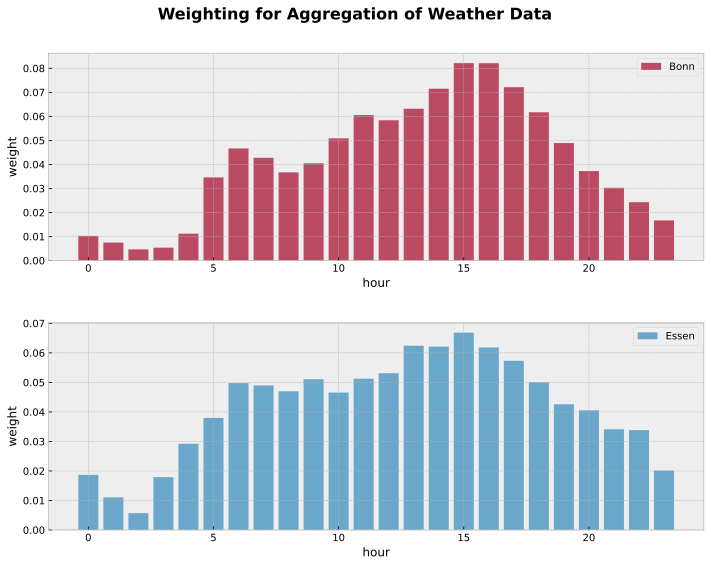

In [10]:
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(10, 8))
# Bonn
ax1.bar(range(24), weighting_bonn, alpha=0.7, color='C1')
ax1.set_xlabel("hour")
ax1.set_ylabel("weight")
ax1.legend(['Bonn'])

# Essen
ax2.bar(range(24), weighting_essen, alpha=0.7)
ax2.set_xlabel("hour")
ax2.set_ylabel("weight")
ax2.legend(['Essen'])

fig.tight_layout()
fig.suptitle("Weighting for Aggregation of Weather Data", fontweight="bold", fontsize=16)
fig.subplots_adjust(top=0.9, hspace=0.3)

In [11]:
# Join demand and weather data (Bonn)
df_bonn = df_demand_bonn.join(df_weather_bonn_wavg, on="day", how="outer")
df_bonn = df_bonn[df_bonn.index.notna()] # remove entries where data is NaT
df_bonn = df_bonn.drop(["day"], axis=1)

# Join demand and weather data (Essen)
df_essen = df_demand_essen.join(df_weather_essen_wavg, on="day", how="outer")
df_essen = df_essen[df_essen.index.notna()] # remove entries where data is NaT
df_essen = df_essen.drop(["day"], axis=1)

---

## Feature Selection Criteria

To select suitable features for our regression models we first examined the correlation among the features (especially `demand`).

In [12]:
# Plot a simple linear regression between demand and every other feature
def plot_all_features(city):
    df = df_bonn if city=="Bonn" else df_essen
    for i, feature in enumerate(df_bonn.columns[1:]):
        fig, ax = plt.subplots(figsize=(12, 4))
        ax.set_title(f"{feature} vs Demand", fontsize=16, fontweight="bold", pad=20)
        ax.set_xlabel(feature)
        ax.set_ylabel("demand")
        ax.scatter(df[feature], df["demand"], marker="x", label="Observation on a specific day")
        
        # Simple linear regression
        df_dropped = df[[feature, "demand"]].dropna() 
        X = pd.DataFrame(df_dropped[feature])
        y = df_dropped["demand"]
        model = LinearRegression()
        model.fit(X, y)
        x_space = np.linspace(df[feature].min(), df[feature].max(), 100).reshape(100, 1)
        y_pred = model.predict(x_space)
        ax.plot(x_space, y_pred, c="red", label="Linear Regression")
        ax.legend(loc="lower right")

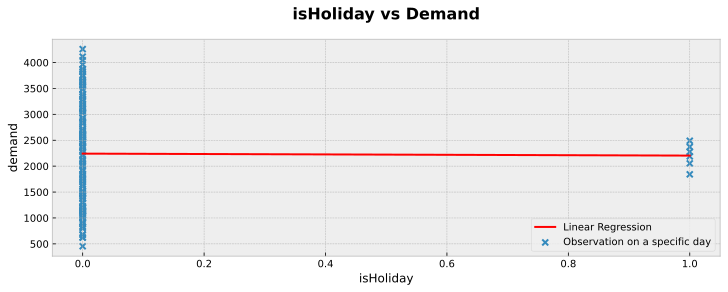

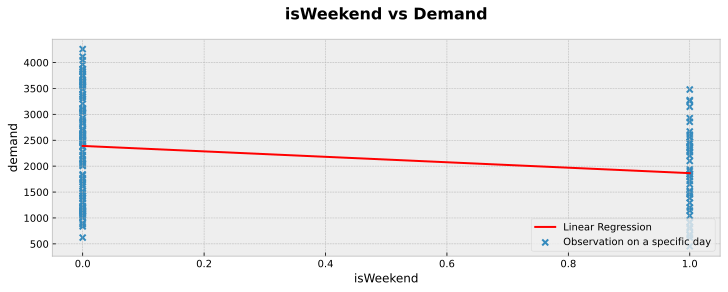

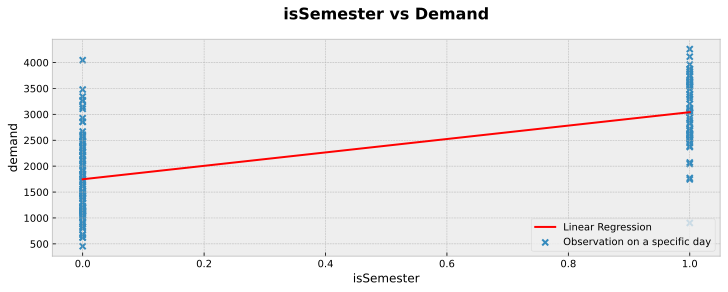

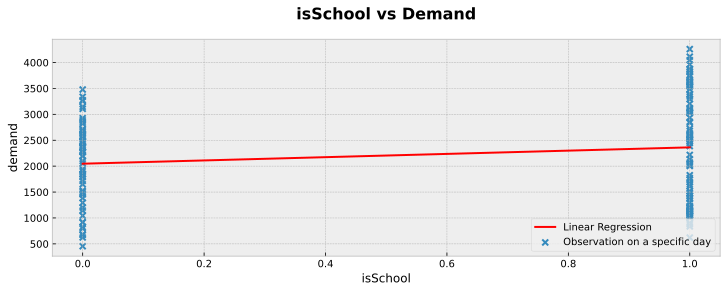

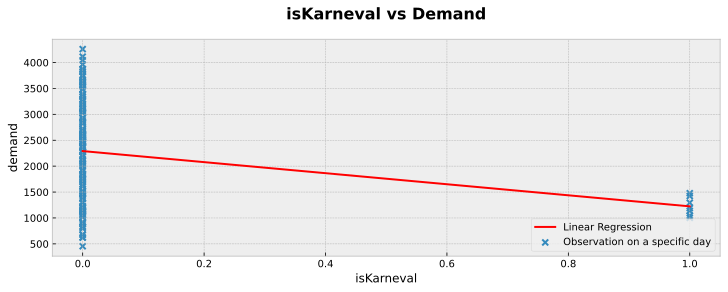

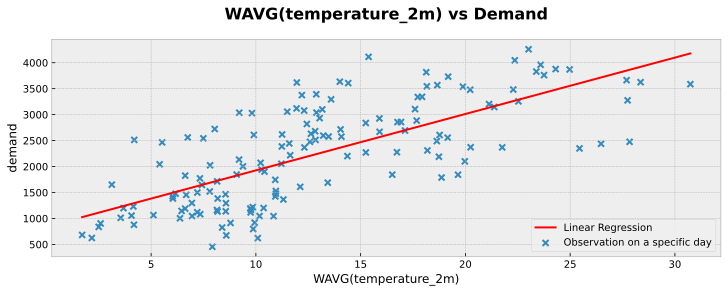

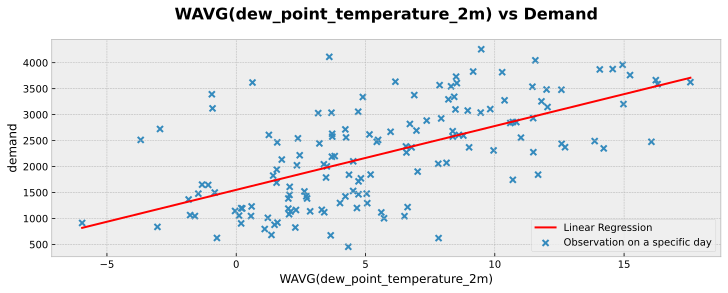

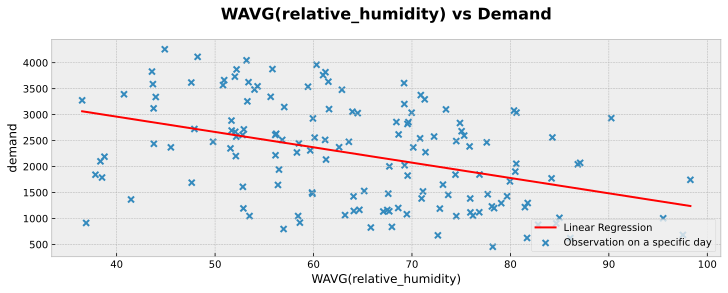

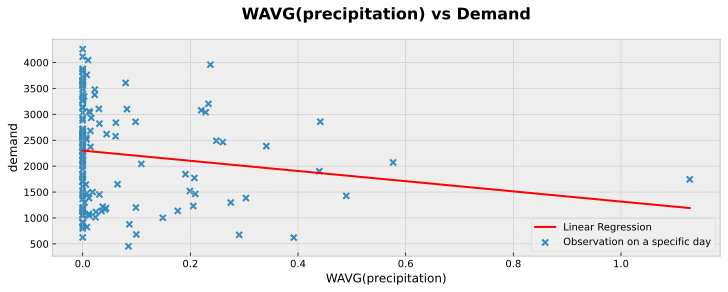

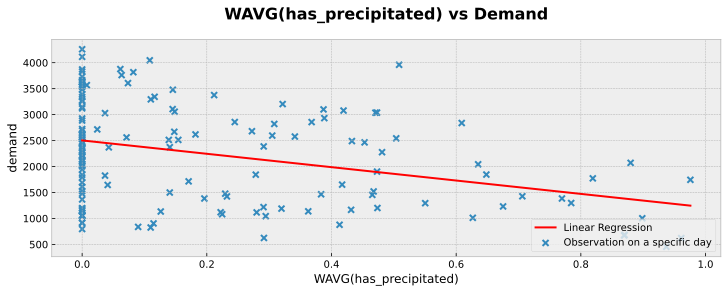

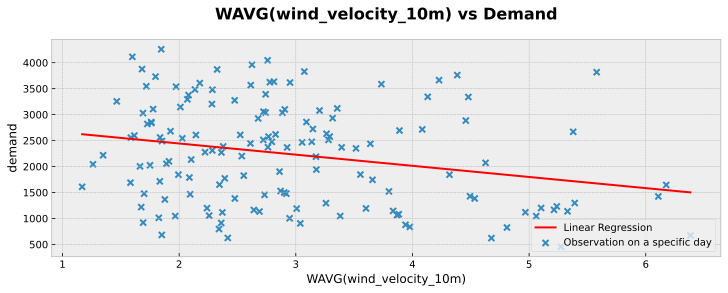

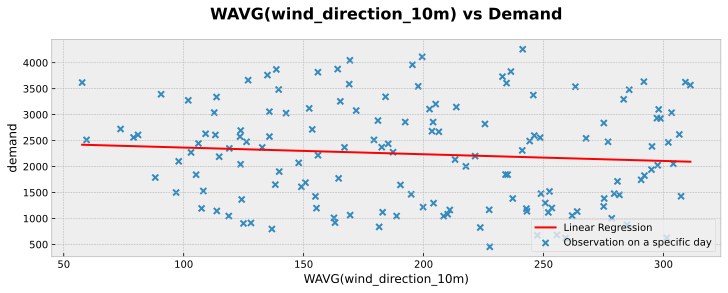

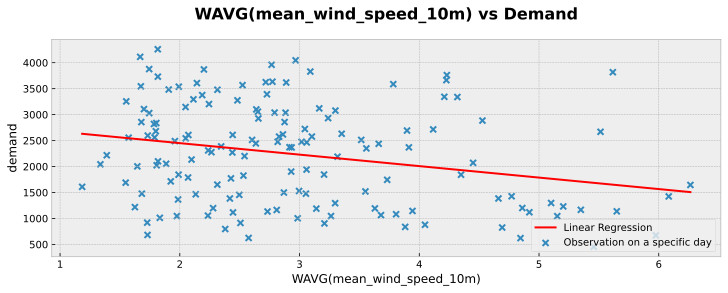

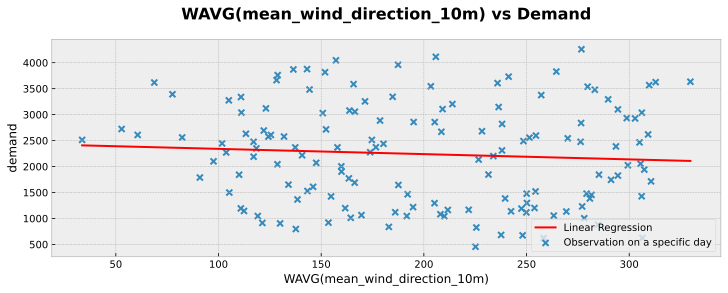

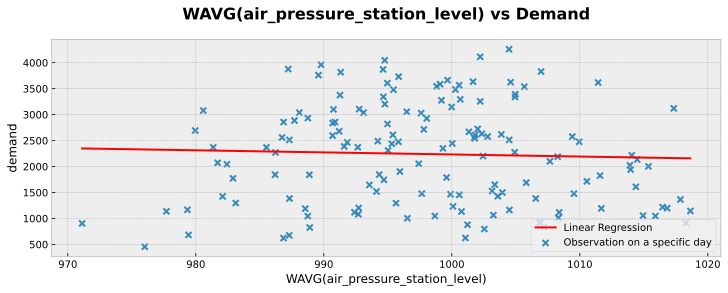

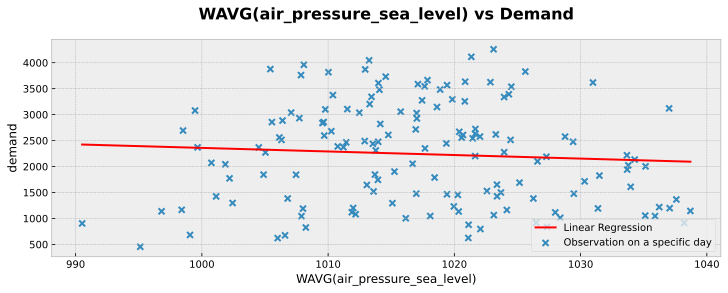

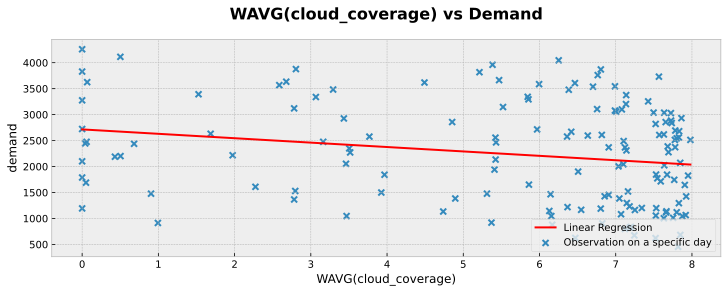

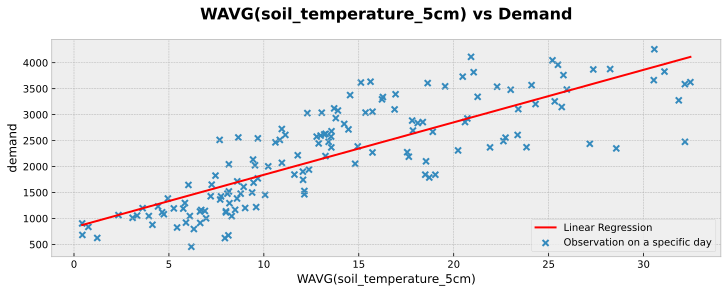

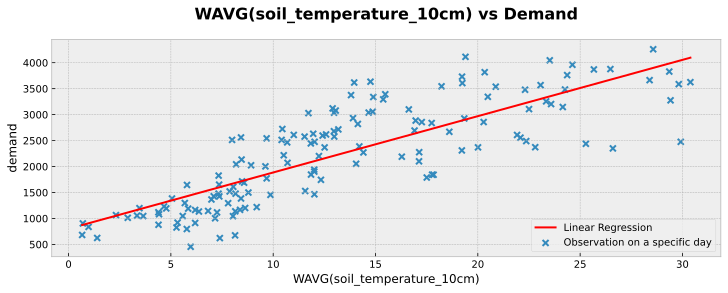

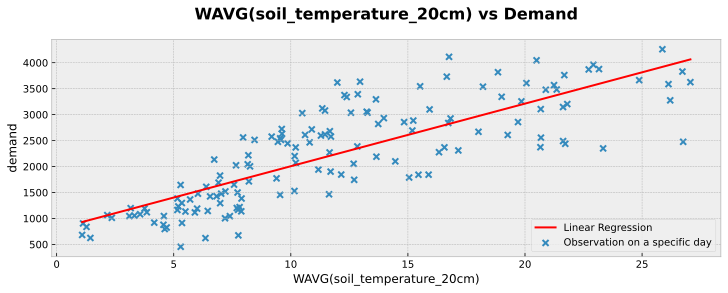

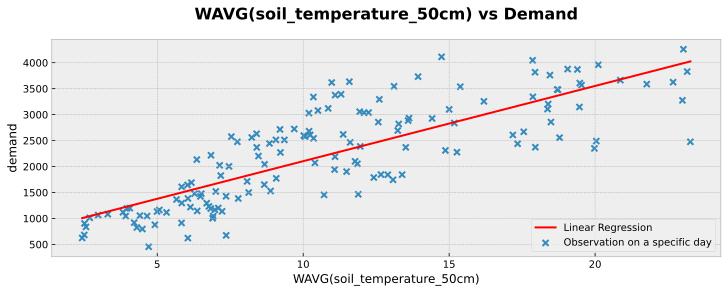

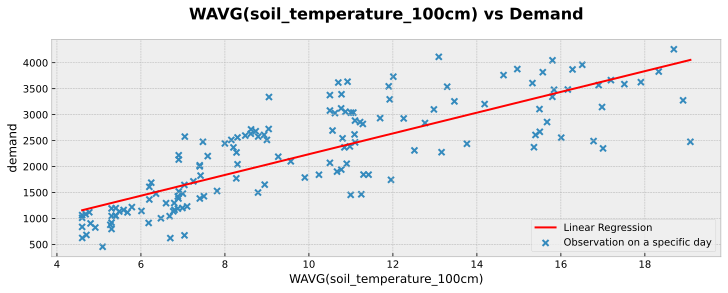

In [13]:
plot_all_features("Bonn")

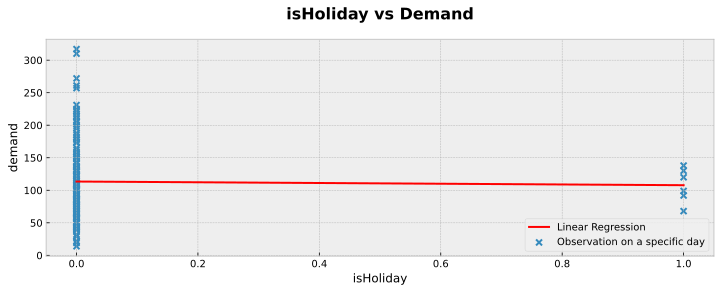

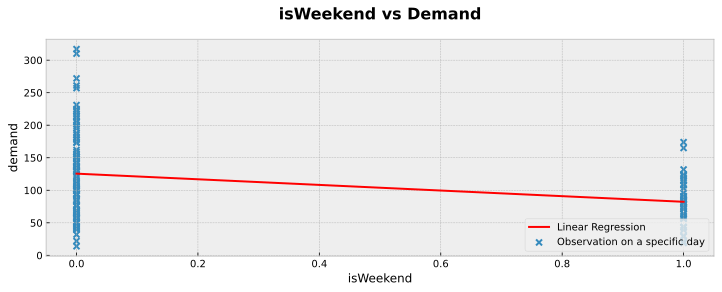

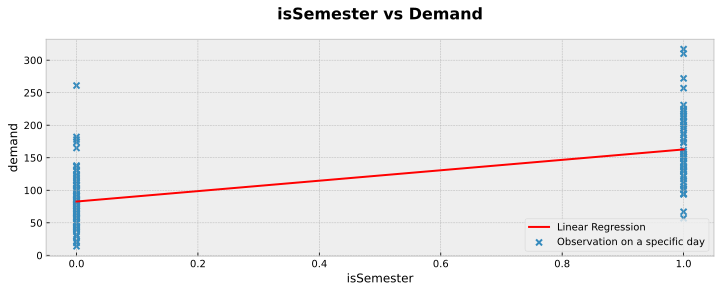

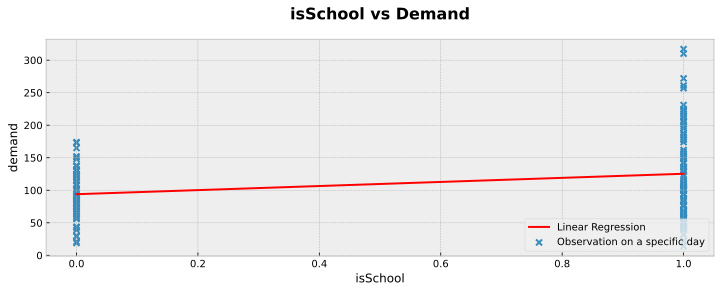

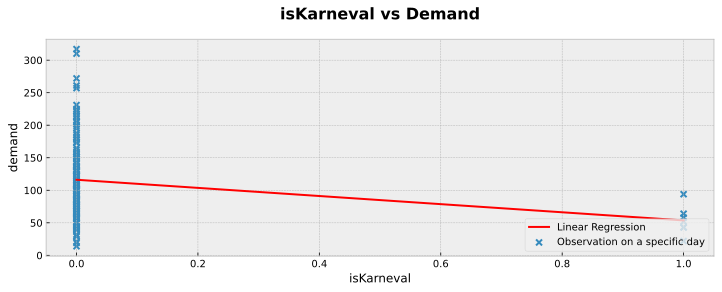

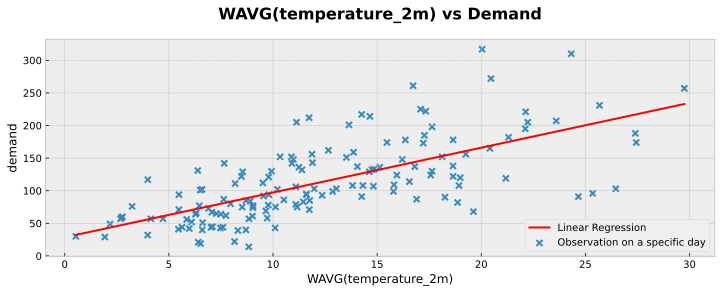

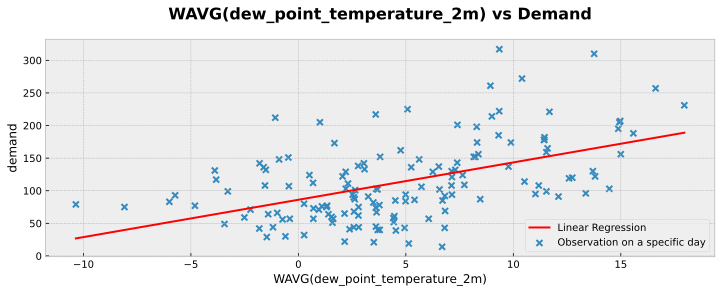

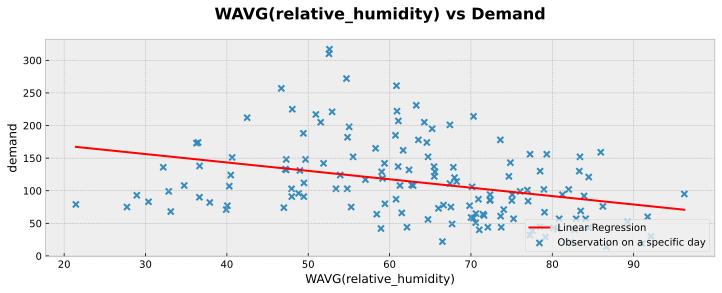

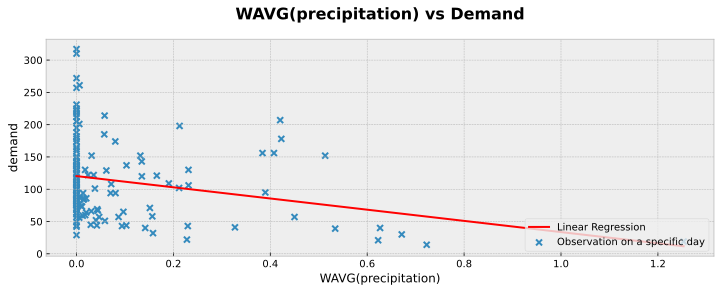

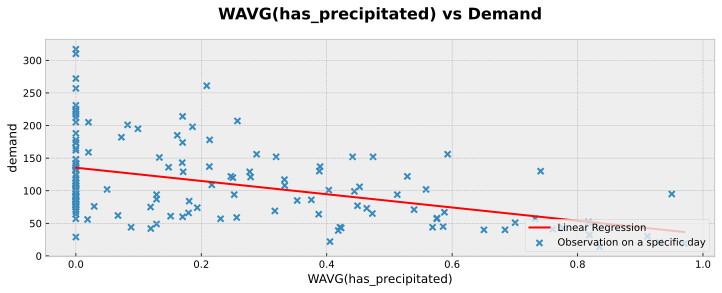

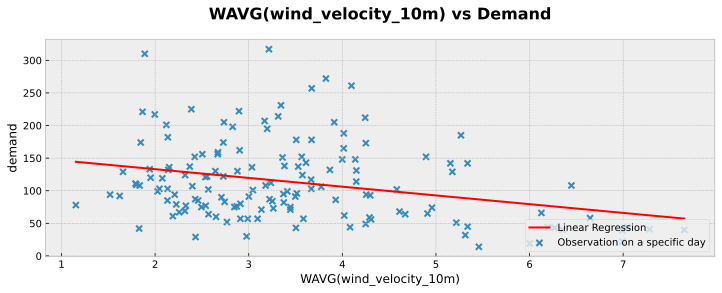

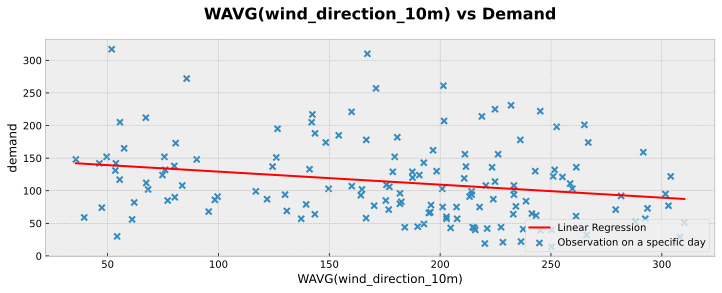

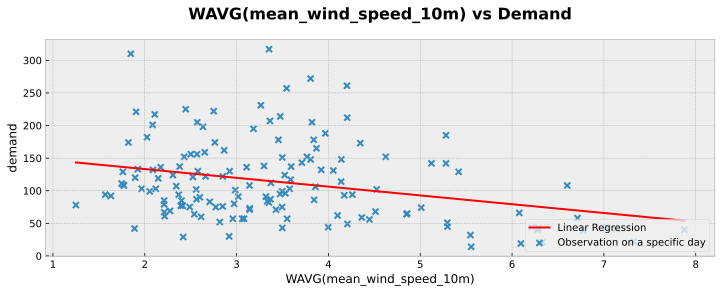

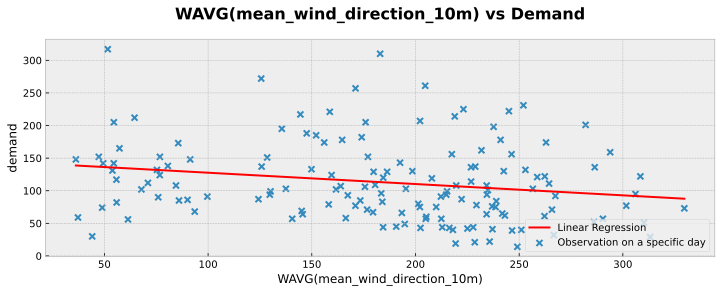

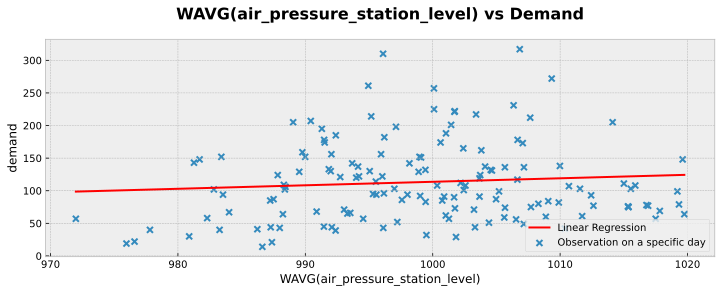

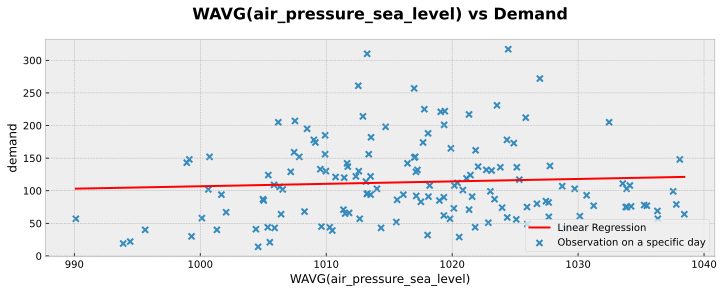

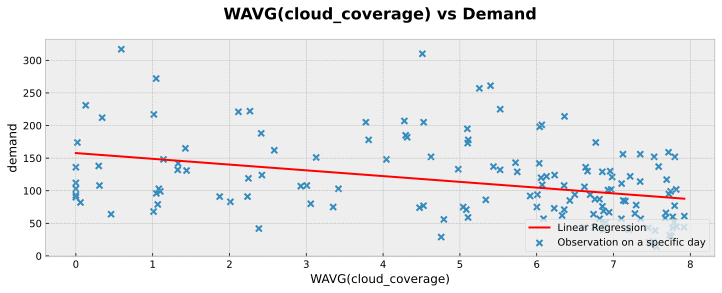

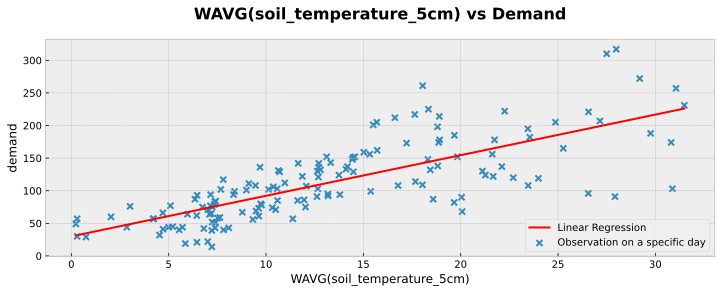

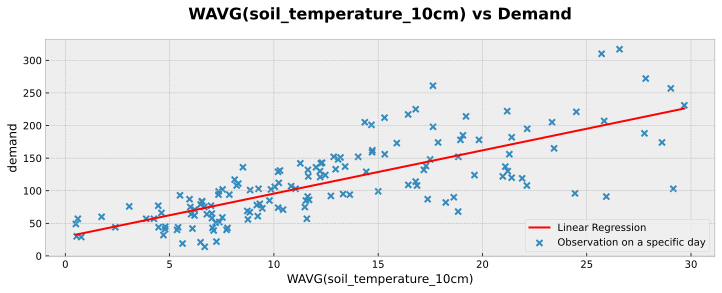

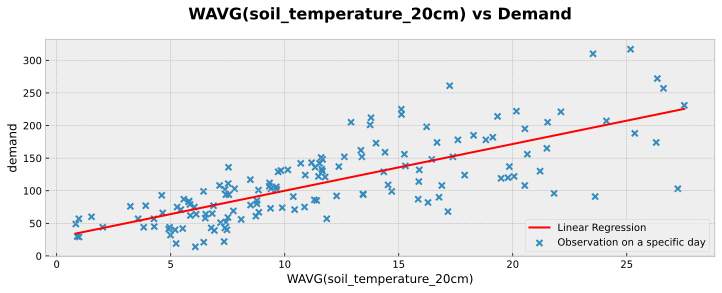

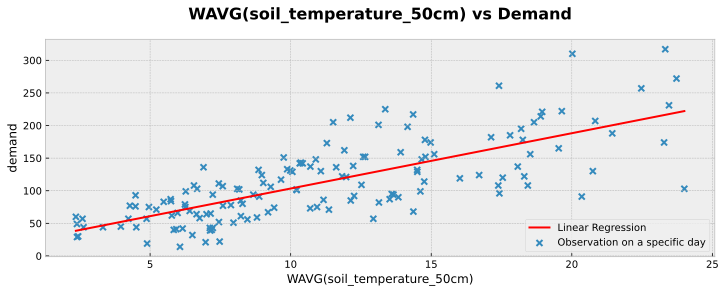

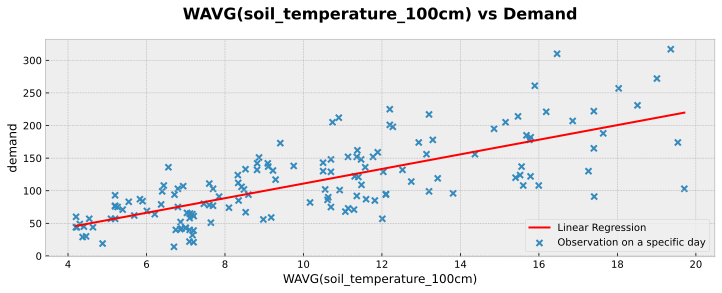

In [14]:
plot_all_features("Essen")

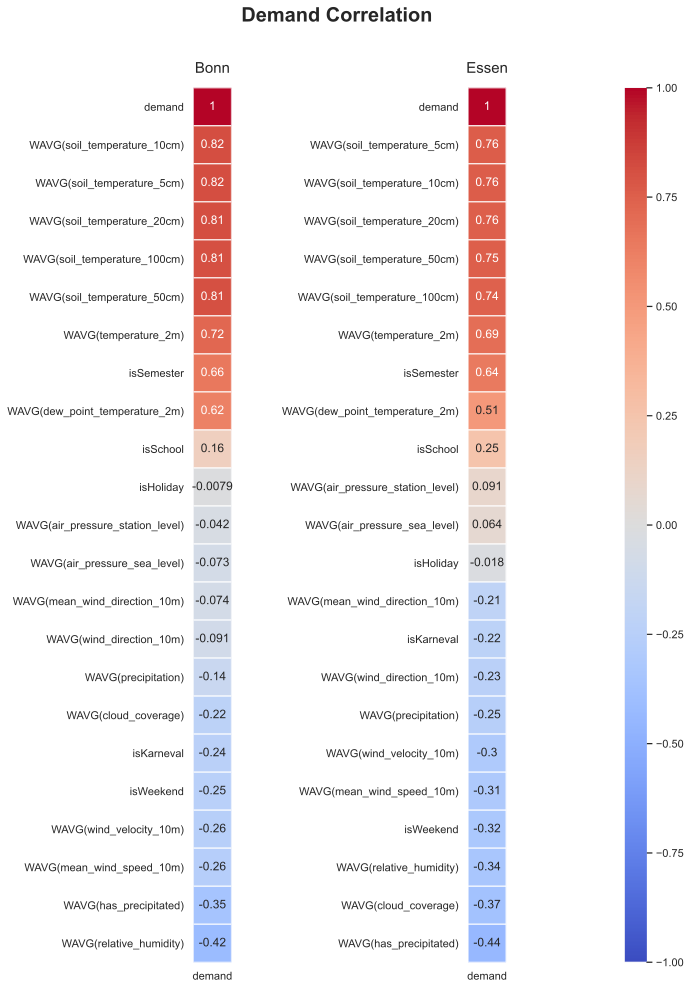

In [15]:
sns.set_theme()
f,(ax1,ax2, axcb) = plt.subplots(1,3, 
                                 gridspec_kw={'width_ratios':[1,1,0.08]}, 
                                 figsize=(10,14))
ax1.get_shared_y_axes().join(ax2)
g1 = sns.heatmap(df_bonn.corr()[['demand']].sort_values(by='demand', ascending=False), 
                 annot = True, 
                 fmt='.2g', 
                 vmin=-1, 
                 vmax=1, 
                 center=0, 
                 cmap='coolwarm', 
                 linewidths=1, 
                 square=True, 
                 cbar=False, 
                 ax=ax1)

g1.set_title("Bonn", fontsize=15, pad=15)
g2 = sns.heatmap(df_essen.corr()[['demand']].sort_values(by='demand', ascending=False), 
                 annot = True, 
                 fmt='.2g', 
                 vmin=-1, 
                 vmax=1, 
                 center=0, 
                 cmap='coolwarm', 
                 linewidths=1, 
                 square=True, 
                 ax=ax2, 
                 cbar_ax=axcb)
g2.set_title("Essen", fontsize=15, pad=15)

f.tight_layout()
f.suptitle('Demand Correlation', fontweight="bold", fontsize=20)
f.subplots_adjust(top=0.9)

#plt.savefig('Demand Correlation.png', bbox_inches='tight')
plt.show()

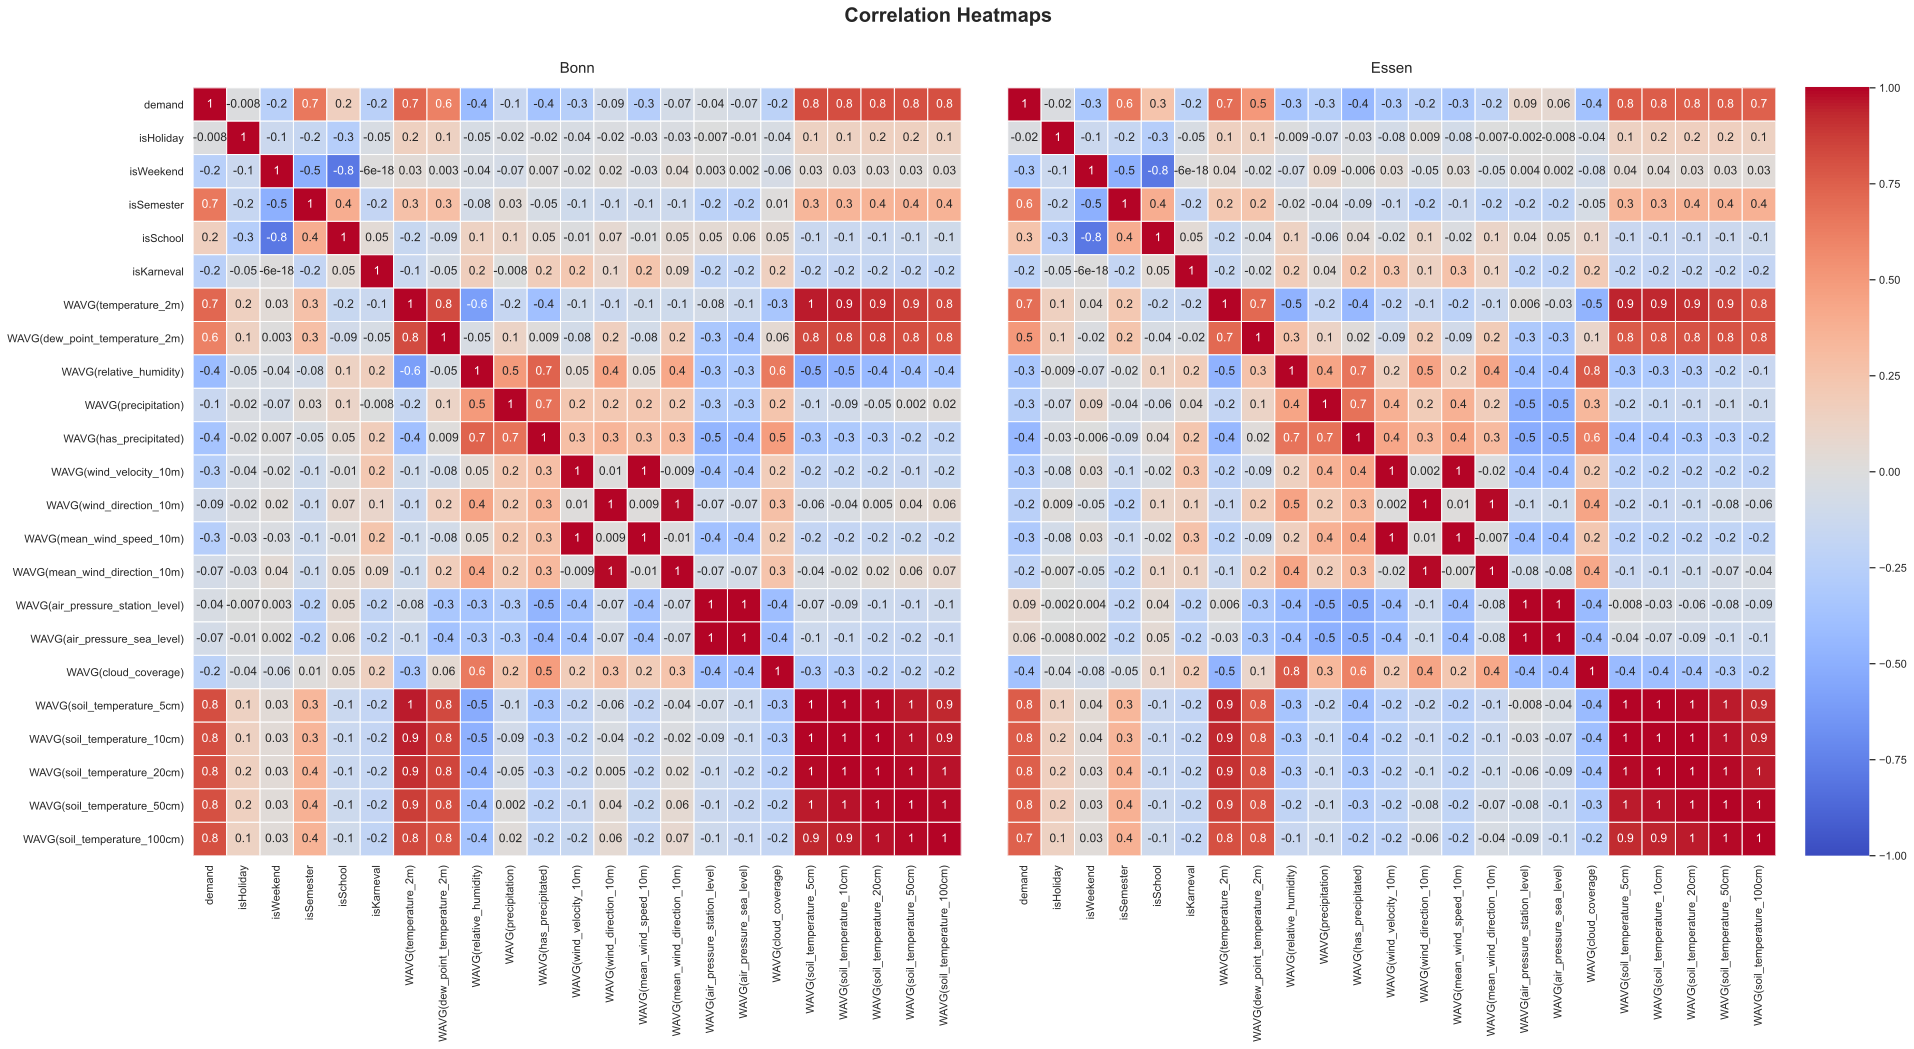

In [16]:
f,(ax1,ax2, axcb) = plt.subplots(1,3, 
                                 gridspec_kw={'width_ratios':[1,1,0.08]}, 
                                 figsize=(27,14))
ax1.get_shared_y_axes().join(ax2)
g1 = sns.heatmap(df_bonn.corr(), 
                 annot = True, 
                 fmt='.1g', 
                 vmin=-1, 
                 vmax=1, 
                 center=0, 
                 cmap='coolwarm', 
                 linewidths=1, 
                 square=True, 
                 cbar=False, 
                 ax=ax1)
g1.set_ylabel('')
g1.set_xlabel('')
g1.set_title("Bonn", fontsize=15, pad=15)
g2 = sns.heatmap(df_essen.corr(), 
                 annot = True, 
                 fmt='.1g', 
                 vmin=-1, 
                 vmax=1, 
                 center=0, 
                 cmap='coolwarm', 
                 linewidths=1, 
                 square=True, 
                 ax=ax2, 
                 cbar_ax=axcb)
g2.set_ylabel('')
g2.set_xlabel('')
g2.set_yticks([])
g2.set_title("Essen", fontsize=15, pad=15)

# may be needed to rotate the ticklabels correctly:
for ax in [g1,g2]:
    tl = ax.get_xticklabels()
    ax.set_xticklabels(tl, rotation=90)
    tly = ax.get_yticklabels()
    ax.set_yticklabels(tly, rotation=0)

f.tight_layout()
f.suptitle('Correlation Heatmaps', fontweight="bold", fontsize=20)
f.subplots_adjust(top=0.9)

#plt.savefig('heatmaps.pdf', bbox_inches='tight')
plt.show()

## Picking features 

In [17]:
all_features = [ 
    'isHoliday',
    'isWeekend', 
    'isSemester', 
    'isSchool',
    'isKarneval', 
    'WAVG(temperature_2m)', 
    'WAVG(dew_point_temperature_2m)',
    'WAVG(relative_humidity)', 
    'WAVG(precipitation)',
    'WAVG(has_precipitated)', 
    'WAVG(wind_velocity_10m)',
    'WAVG(wind_direction_10m)', 
    'WAVG(mean_wind_speed_10m)',
    'WAVG(mean_wind_direction_10m)',
    'WAVG(air_pressure_station_level)',
    'WAVG(air_pressure_sea_level)', 
    'WAVG(cloud_coverage)',
    'WAVG(soil_temperature_5cm)', 
    'WAVG(soil_temperature_10cm)',
    'WAVG(soil_temperature_20cm)', 
    'WAVG(soil_temperature_50cm)',
    'WAVG(soil_temperature_100cm)'
]

features = [
    'isWeekend', 
    'isSemester', 
    'isSchool',
    'isKarneval', 
    'WAVG(temperature_2m)', 
    'WAVG(has_precipitated)', 
    'WAVG(mean_wind_speed_10m)',
    'WAVG(cloud_coverage)',
    'WAVG(soil_temperature_100cm)'
]

In [18]:
X_bonn, y_bonn = df_bonn[features], df_bonn["demand"]
# Create training, validation and test data:
X_bonn_train, X_bonn_test, y_bonn_train, y_bonn_test = train_test_split(X_bonn, y_bonn, test_size=0.2, random_state=42)
X_bonn_train, X_bonn_val, y_bonn_train, y_bonn_val = train_test_split(X_bonn_train, y_bonn_train, test_size=0.25, random_state=42)

In [19]:
X_essen, y_essen = df_essen[features], df_essen["demand"]
# Create training, validation and test data:
X_essen_train, X_essen_test, y_essen_train, y_essen_test = train_test_split(X_essen, y_essen, test_size=0.2, random_state=42)
X_essen_train, X_essen_val, y_essen_train, y_essen_val = train_test_split(X_essen_train, y_essen_train, test_size=0.25, random_state=42)

In [20]:
X_bonn_train

isWeekend  isSemester  isSchool  isKarneval  WAVG(temperature_2m)  \
2019-02-21        0.0         0.0       1.0         0.0              9.749063   
2019-06-20        0.0         0.0       0.0         0.0             18.636263   
2019-05-27        0.0         1.0       1.0         0.0             15.245638   
2019-03-20        0.0         0.0       1.0         0.0              9.197641   
2019-05-24        0.0         1.0       1.0         0.0             19.177253   
...               ...         ...       ...         ...                   ...   
2019-05-31        0.0         1.0       1.0         0.0             19.881334   
2019-04-01        0.0         1.0       1.0         0.0             11.593711   
2019-05-03        0.0         1.0       1.0         0.0              9.206259   
2019-04-25        0.0         1.0       0.0         0.0             17.673517   
2019-03-28        0.0         0.0       1.0         0.0              9.382358   

            WAVG(has_precipitated)  WAVG(mean_wind_speed_10m)  \
2019-02-21                0.279906                   2.444299   
2019-06-20                0.432761                   1.958966   
2019-05-27                0.608908                   1.804018   
2019-03-20                0.000000                   2.097938   
2019-05-24                0.000000                   1.816661   
...                            ...                        ...   
2019-05-31                0.000000                   1.991544   
2019-04-01                0.000000                   2.635041   
2019-05-03                0.470452                   2.883112   
2019-04-25                0.000000                   4.527365   
2019-03-28                0.000000                   1.645252   

            WAVG(cloud_coverage)  WAVG(soil_temperature_100cm)  
2019-02-21              7.659653                      5.680038  
2019-06-20              7.103750                     16.778311  
2019-05-27              7.734631                     12.764282  
2019-03-20              5.424344                      6.900000  
2019-05-24              7.566562                     12.009892  
...                          ...                           ...  
2019-05-31              6.701474                     13.292646  
2019-04-01              0.040138                      7.998832  
2019-05-03              7.635323                     11.001669  
2019-04-25              7.725697                     11.097143  
2019-03-28              7.036130                      7.400000  

[87 rows x 9 columns]

---

# Training a Regression Model

In [21]:
r2_bonn = []
r2_essen = []

# function for plotting
def plot_scikit_output(x, y, model, feature, name, city, label=None):
    min_x, max_x = x.min(), x.max()
    x_space = np.linspace(min_x, max_x, 400)
    color = 'C3' if city=="Bonn" else 'C0'
    # plotting routine
    plt.figure(figsize=(8, 6))
    plt.scatter(x, y, marker="x", color='C2')
    plt.plot(x_space, model.predict(x_space.reshape(-1, 1)), color=color, label=label)
    plt.xlabel(feature)
    plt.ylabel("Demand")
    plt.legend()
    plt.title(name, fontsize=16, fontweight="bold", pad=20)
    plt.tight_layout()

## Linear Regression

### Bonn

In [22]:
lr_bonn = LinearRegression(normalize=True)
lr_bonn.fit(X_bonn_train, y_bonn_train)
# Training R2 score (1.0 is best):
lr_bonn.score(X_bonn_train, y_bonn_train)

0.8533626186800816

In [23]:
# Validation R2 score (1.0 is best):
y_bonn_pred_lr = lr_bonn.predict(X_bonn_val)
lr_bonn.score(X_bonn_val, y_bonn_val)

0.7157979308982834

In [24]:
r2_bonn.append(r2_score(y_bonn_val, y_bonn_pred_lr))
print("MSE:", mean_squared_error(y_bonn_val, y_bonn_pred_lr))
print("MAE:", mean_absolute_error(y_bonn_val, y_bonn_pred_lr))
print("R2: ", r2_score(y_bonn_val, y_bonn_pred_lr))

MSE: 211483.71545734495
MAE: 362.6890928917489
R2:  0.7157979308982834


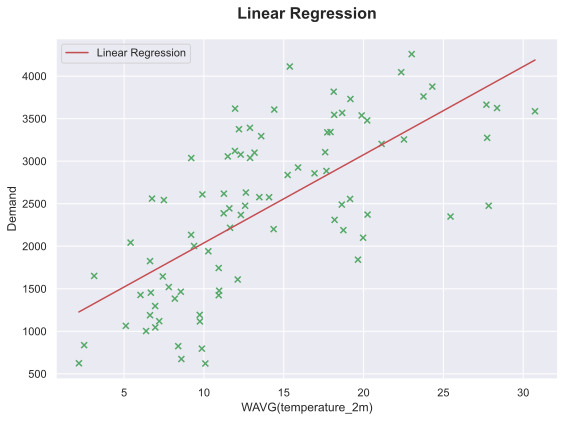

In [25]:
lr_feature = "WAVG(temperature_2m)"
lr_bonn = LinearRegression().fit(X_bonn_train[lr_feature].values.reshape(-1, 1), y_bonn_train)
plot_scikit_output(X_bonn_train[lr_feature], y_bonn_train, lr_bonn, lr_feature, "Linear Regression", "Bonn", "Linear Regression")

### Essen

In [26]:
lr_essen = LinearRegression(normalize=True)
lr_essen.fit(X_essen_train, y_essen_train)
# Training R2 score (1.0 is best):
lr_essen.score(X_essen_train, y_essen_train)

0.8154961860241439

In [27]:
# Validation R2 score (1.0 is best):
y_essen_pred_lr = lr_essen.predict(X_essen_val)
lr_essen.score(X_essen_val, y_essen_val)

0.7111862173700843

In [28]:
r2_essen.append(r2_score(y_essen_val, y_essen_pred_lr))
print("MSE:", mean_squared_error(y_essen_val, y_essen_pred_lr))
print("MAE:", mean_absolute_error(y_essen_val, y_essen_pred_lr))
print("R2: ", r2_score(y_essen_val, y_essen_pred_lr))

MSE: 550.3856865695692
MAE: 18.111860237749212
R2:  0.7111862173700843


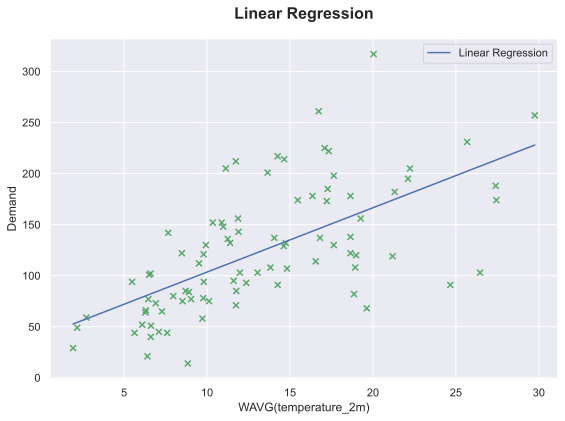

In [29]:
lr_feature = "WAVG(temperature_2m)"
lr_essen = LinearRegression().fit(X_essen_train[lr_feature].values.reshape(-1, 1), y_essen_train)
plot_scikit_output(X_essen_train[lr_feature], y_essen_train, lr_essen, lr_feature, "Linear Regression", "Essen", "Linear Regression")

---

## Lasso Regression

### Bonn

Text(0.5, 1.0, 'Lasso Regression Error Validation')

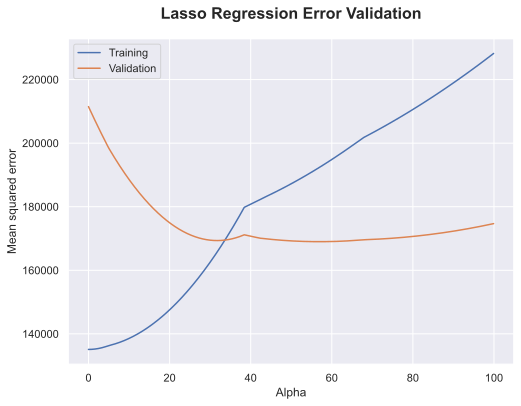

In [30]:
# Search the best lasso alpha
err_train_lasso = []
err_val_lasso = []

for alpha in np.arange(0, 100, 0.1):
    # Fit model
    lasso_reg_bonn = Lasso(alpha=alpha)
    lasso_model_bonn = lasso_reg_bonn.fit(X_bonn_train, y_bonn_train)
    
    # Compute errors
    err_train_lasso.append(mean_squared_error(y_bonn_train, lasso_model_bonn.predict(X_bonn_train)))
    err_val_lasso.append(mean_squared_error(y_bonn_val, lasso_model_bonn.predict(X_bonn_val)))
    
plt.figure(figsize=(8, 6))
plt.plot(np.arange(0, 100, 0.1), err_train_lasso, np.arange(0, 100, 0.1), err_val_lasso)
plt.legend(["Training", "Validation"])
plt.xlabel("Alpha")
plt.ylabel("Mean squared error")
plt.title("Lasso Regression Error Validation", fontsize=16, fontweight="bold", pad=20)

In [31]:
print("Best validation value for", np.argmin(err_val_lasso)/10, "alpha")

Best validation value for 56.9 alpha


In [32]:
lasso_reg_bonn = Lasso(alpha=np.argmin(err_val_lasso)/10)
lasso_model_bonn = lasso_reg_bonn.fit(X_bonn_train, y_bonn_train)

y_bonn_pred_lasso = lasso_model_bonn.predict(X_bonn_val)

In [33]:
r2_bonn.append(r2_score(y_bonn_val, y_bonn_pred_lasso))
print("MSE:", mean_squared_error(y_bonn_val, y_bonn_pred_lasso))
print("MAE:", mean_absolute_error(y_bonn_val, y_bonn_pred_lasso))
print("R2: ", r2_score(y_bonn_val, y_bonn_pred_lasso))

MSE: 169003.32818902362
MAE: 343.86432659164734
R2:  0.7728851346661507


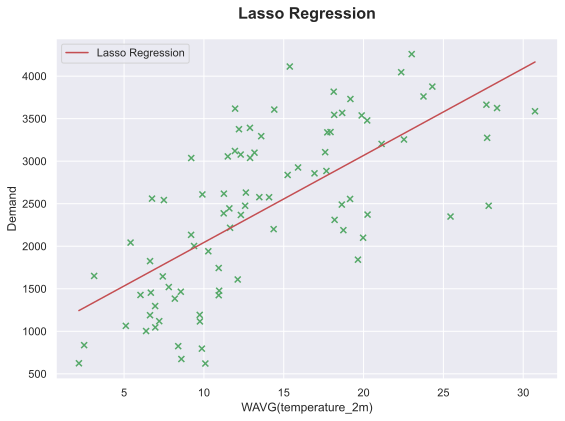

In [34]:
lasso_feature = "WAVG(temperature_2m)"
lasso_bonn = Lasso(alpha=np.argmin(err_val_lasso)/10).fit(X_bonn_train[lasso_feature].values.reshape(-1, 1), y_bonn_train)
plot_scikit_output(X_bonn_train[lasso_feature], y_bonn_train, lasso_bonn, lasso_feature, "Lasso Regression", "Bonn", "Lasso Regression")

### Essen

Text(0.5, 1.0, 'Lasso Regression Error Validation')

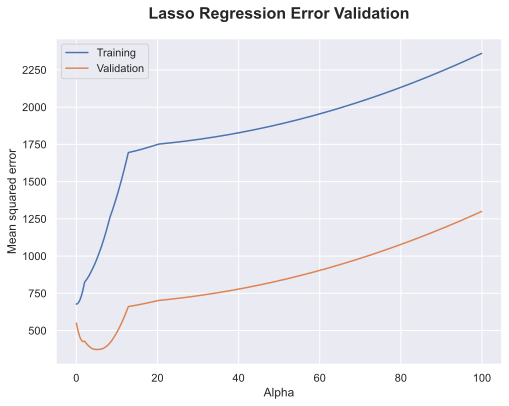

In [35]:
# Search the best lasso alpha
err_train_lasso = []
err_val_lasso = []

for alpha in np.arange(0, 100, 0.1):
    # Fit model
    lasso_reg_essen = Lasso(alpha=alpha)
    lasso_model_essen = lasso_reg_essen.fit(X_essen_train, y_essen_train)
    
    # Compute errors
    err_train_lasso.append(mean_squared_error(y_essen_train, lasso_model_essen.predict(X_essen_train)))
    err_val_lasso.append(mean_squared_error(y_essen_val, lasso_model_essen.predict(X_essen_val)))
    
plt.figure(figsize=(8, 6))
plt.plot(np.arange(0, 100, 0.1), err_train_lasso, np.arange(0, 100, 0.1), err_val_lasso)
plt.legend(["Training", "Validation"])
plt.xlabel("Alpha")
plt.ylabel("Mean squared error")
plt.title("Lasso Regression Error Validation", fontsize=16, fontweight="bold", pad=20)

In [36]:
print("Best validation value for", np.argmin(err_val_lasso)/10, "alpha")

Best validation value for 4.9 alpha


In [37]:
lasso_reg_essen = Lasso(alpha=np.argmin(err_val_lasso)/10)
lasso_model_essen = lasso_reg_essen.fit(X_essen_train, y_essen_train)

y_essen_pred_lasso = lasso_model_essen.predict(X_essen_val)

In [38]:
r2_essen.append(r2_score(y_essen_val, y_essen_pred_lasso))
print("MSE:", mean_squared_error(y_essen_val, y_essen_pred_lasso))
print("MAE:", mean_absolute_error(y_essen_val, y_essen_pred_lasso))
print("R2: ", r2_score(y_essen_val, y_essen_pred_lasso))

MSE: 372.89120438467904
MAE: 13.696566704890975
R2:  0.8043260900932763


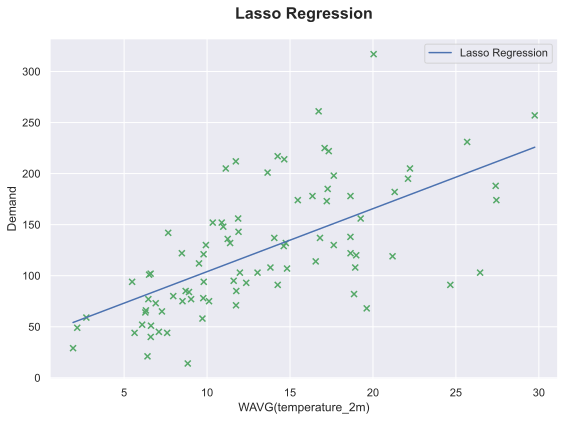

In [39]:
lasso_feature = "WAVG(temperature_2m)"
lasso_essen = Lasso(alpha=np.argmin(err_val_lasso)/10).fit(X_essen_train[lasso_feature].values.reshape(-1, 1), y_essen_train)
plot_scikit_output(X_essen_train[lasso_feature], y_essen_train, lasso_essen, lasso_feature, "Lasso Regression", "Essen", "Lasso Regression")

---

## Ridge Regression

### Bonn

Text(0.5, 1.0, 'Ridge Regression Error Validation')

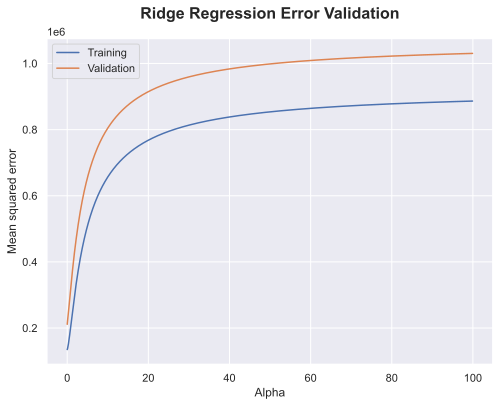

In [40]:
# Search the best lasso alpha
err_train_ridge = []
err_val_ridge = []

for alpha in np.arange(0, 100, 0.1):
    # Fit model
    ridge_reg_bonn = Ridge(alpha=alpha, normalize=True, solver='lsqr')
    ridge_model_bonn = ridge_reg_bonn.fit(X_bonn_train, y_bonn_train)
    
    # Compute errors
    err_train_ridge.append(mean_squared_error(y_bonn_train, ridge_model_bonn.predict(X_bonn_train)))
    err_val_ridge.append(mean_squared_error(y_bonn_val, ridge_model_bonn.predict(X_bonn_val)))
    
plt.figure(figsize=(8, 6))
plt.plot(np.arange(0, 100, 0.1), err_train_ridge, np.arange(0, 100, 0.1), err_val_ridge)
plt.legend(["Training", "Validation"])
plt.xlabel("Alpha")
plt.ylabel("Mean squared error")
plt.title("Ridge Regression Error Validation", fontsize=16, fontweight="bold", pad=20)

In [41]:
print("Best validation value for", np.argmin(err_val_ridge)/10, "alpha")

Best validation value for 0.0 alpha


In [42]:
ridge_reg_bonn = Ridge(alpha=np.argmin(err_val_ridge)/10, normalize=True, solver='lsqr')
ridge_model_bonn = ridge_reg_bonn.fit(X_bonn_train, y_bonn_train)

y_bonn_pred_ridge = ridge_model_bonn.predict(X_bonn_val)

In [43]:
r2_bonn.append(r2_score(y_bonn_val, y_bonn_pred_ridge))
print("MSE:", mean_squared_error(y_bonn_val, y_bonn_pred_ridge))
print("MAE:", mean_absolute_error(y_bonn_val, y_bonn_pred_ridge))
print("R2: ", r2_score(y_bonn_val, y_bonn_pred_ridge))

MSE: 211483.71545735872
MAE: 362.68909289176196
R2:  0.7157979308982648


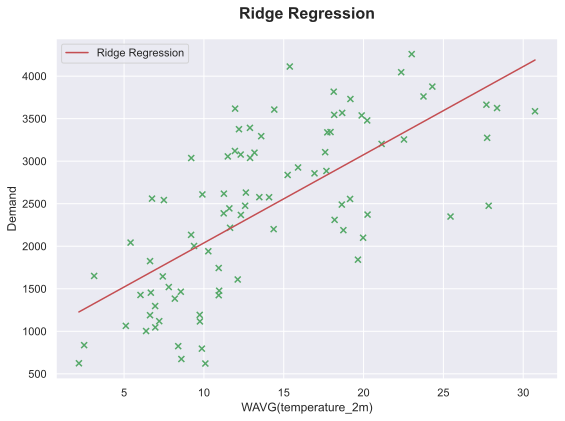

In [44]:
ridge_feature = "WAVG(temperature_2m)"
ridge_bonn = Ridge(alpha=np.argmin(err_val_ridge)/10, normalize=True, solver='lsqr').fit(X_bonn_train[ridge_feature].values.reshape(-1, 1), y_bonn_train)
plot_scikit_output(X_bonn_train[ridge_feature], y_bonn_train, ridge_bonn, ridge_feature, "Ridge Regression", "Bonn", "Ridge Regression")

### Essen

Text(0.5, 1.0, 'Ridge Regression Error Validation')

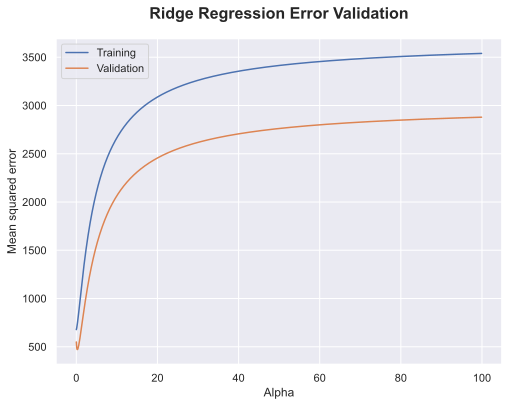

In [45]:
# Search the best lasso alpha
err_train_ridge = []
err_val_ridge = []

for alpha in np.arange(0, 100, 0.1):
    # Fit model
    ridge_reg_essen = Ridge(alpha=alpha, normalize=True, solver='lsqr')
    ridge_model_essen = ridge_reg_essen.fit(X_essen_train, y_essen_train)
    
    # Compute errors
    err_train_ridge.append(mean_squared_error(y_essen_train, ridge_model_essen.predict(X_essen_train)))
    err_val_ridge.append(mean_squared_error(y_essen_val, ridge_model_essen.predict(X_essen_val)))
    
plt.figure(figsize=(8, 6))
plt.plot(np.arange(0, 100, 0.1), err_train_ridge, np.arange(0, 100, 0.1), err_val_ridge)
plt.legend(["Training", "Validation"])
plt.xlabel("Alpha")
plt.ylabel("Mean squared error")
plt.title("Ridge Regression Error Validation", fontsize=16, fontweight="bold", pad=20)

In [46]:
print("Best validation value for", np.argmin(err_val_ridge)/10, "alpha")

Best validation value for 0.3 alpha


In [47]:
ridge_reg_essen = Ridge(alpha=np.argmin(err_val_ridge)/10, normalize=True, solver='lsqr')
ridge_model_essen = ridge_reg_essen.fit(X_essen_train, y_essen_train)

y_essen_pred_ridge = ridge_model_essen.predict(X_essen_val)

In [48]:
r2_essen.append(r2_score(y_essen_val, y_essen_pred_ridge))
print("MSE:", mean_squared_error(y_essen_val, y_essen_pred_ridge))
print("MAE:", mean_absolute_error(y_essen_val, y_essen_pred_ridge))
print("R2: ", r2_score(y_essen_val, y_essen_pred_ridge))

MSE: 471.5659074190825
MAE: 17.222777777432764
R2:  0.7525467380340408


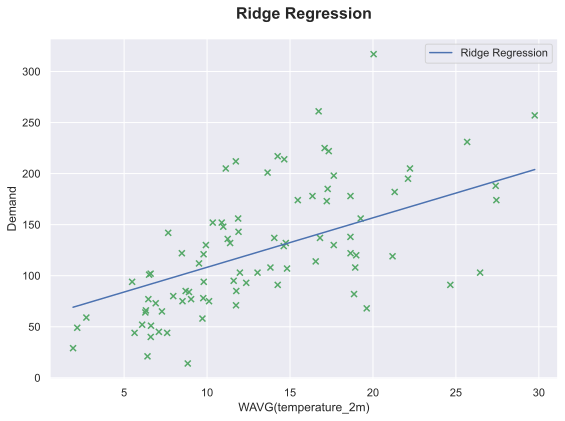

In [49]:
ridge_feature = "WAVG(temperature_2m)"
ridge_essen = Ridge(alpha=np.argmin(err_val_ridge)/10, normalize=True, solver='lsqr').fit(X_essen_train[ridge_feature].values.reshape(-1, 1), y_essen_train)
plot_scikit_output(X_essen_train[ridge_feature], y_essen_train, ridge_essen, ridge_feature, "Ridge Regression", "Essen", "Ridge Regression")

---

## Polynomial Regression

In [50]:
# function for plotting polynomial
def plot_scikit_poly_output(x, y, model, poly, feature, name, city, label=None):
    min_x, max_x = x.min(), x.max()
    x_space = np.linspace(min_x, max_x, 400)
    #x_space = np.arange(min_x, max_x,1)[:, np.newaxis]
    color = 'C3' if city=="Bonn" else 'C0'
    # plotting routine
    plt.figure(figsize=(8, 6))
    plt.scatter(x, y, marker="x", color='C2')
    plt.plot(x_space, model.predict(poly.fit_transform(x_space.reshape(-1, 1))), color=color, label=label)
    plt.xlabel(feature)
    plt.ylabel("Demand")
    plt.legend()
    plt.title(name, fontsize=16, fontweight="bold", pad=20)
    plt.tight_layout()

### Bonn

CPU times: user 23min 2s, sys: 4min 1s, total: 27min 4s
Wall time: 6min 15s


Text(0.5, 1.0, 'Polinomial Regression Error Validation')

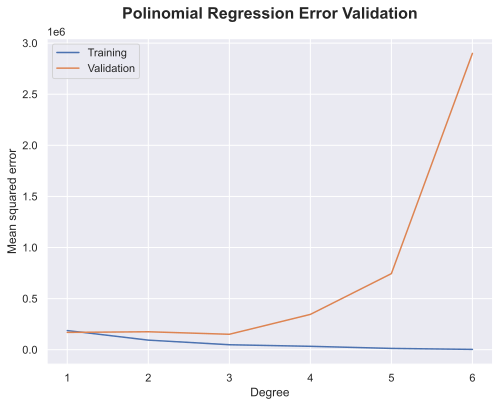

In [51]:
%%time
# Search the best degree and alpha
err_train_poly = []
err_val_poly_bonn = []
alphas_poly_bonn = []

for degree in range(1, 7):
    # Fit model
    poly = PolynomialFeatures(degree=degree)
    err_val = []
    X_poly_train = poly.fit_transform(X_bonn_train)
    X_poly_val = poly.fit_transform(X_bonn_val)
    for alpha in np.arange(0, 50, 0.1):
        poly_reg_bonn = Lasso(alpha=alpha)
        poly_model_bonn = poly_reg_bonn.fit(X_poly_train, y_bonn_train)
        err_val.append(mean_squared_error(y_bonn_val, poly_model_bonn.predict(X_poly_val)))
    
    alphas_poly_bonn.append(np.argmin(err_val)/10)
    poly_reg_bonn = Lasso(alpha=np.argmin(err_val)/10)
    poly_model_bonn = poly_reg_bonn.fit(X_poly_train, y_bonn_train)
    
    # Compute errors
    err_train_poly.append(mean_squared_error(y_bonn_train, poly_model_bonn.predict(X_poly_train)))
    err_val_poly_bonn.append(mean_squared_error(y_bonn_val, poly_model_bonn.predict(X_poly_val)))
    
plt.figure(figsize=(8, 6))
plt.plot(range(1, 7), err_train_poly, range(1, 7), err_val_poly_bonn)
plt.legend(["Training", "Validation"])
plt.xlabel("Degree")
plt.ylabel("Mean squared error")
plt.title("Polinomial Regression Error Validation", fontsize=16, fontweight="bold", pad=20)

In [52]:
alphas_poly_bonn

[49.9, 32.1, 13.6, 49.9, 49.9, 0.1]

In [53]:
print("Best validation value for degree", np.argmin(err_val_poly_bonn)+1, "and alpha", alphas_poly_bonn[np.argmin(err_val_poly_bonn)])

Best validation value for degree 3 and alpha 13.6


In [54]:
# Fit model (for the optimal degree and alpha)
poly = PolynomialFeatures(degree=np.argmin(err_val_poly_bonn)+1)
X_poly_train = poly.fit_transform(X_bonn_train)
X_poly_val = poly.transform(X_bonn_val)
poly_reg_bonn = Lasso(alpha=alphas_poly_bonn[np.argmin(err_val_poly_bonn)])
poly_model_bonn = poly_reg_bonn.fit(X_poly_train, y_bonn_train)

# Predict
y_bonn_pred_poly = poly_model_bonn.predict(X_poly_val)

In [55]:
r2_bonn.append(r2_score(y_bonn_val, y_bonn_pred_poly))
print("MSE:", mean_squared_error(y_bonn_val, y_bonn_pred_poly))
print("MAE:", mean_absolute_error(y_bonn_val, y_bonn_pred_poly))
print("R2: ", r2_score(y_bonn_val, y_bonn_pred_poly))

MSE: 150980.27343888103
MAE: 298.3122299657898
R2:  0.7971053893578514


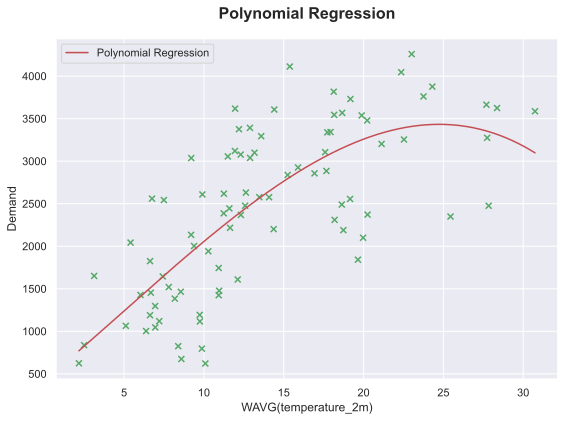

In [56]:
poly_feature = "WAVG(temperature_2m)"
poly = PolynomialFeatures(degree=np.argmin(err_val_poly_bonn)+1)
X_poly_train = poly.fit_transform(X_bonn_train[poly_feature].values.reshape(-1,1))

poly_bonn = Lasso(alpha=alphas_poly_bonn[np.argmin(err_val_poly_bonn)]).fit(X_poly_train, y_bonn_train)
plot_scikit_poly_output(X_bonn_train[poly_feature], y_bonn_train, poly_bonn, poly, poly_feature, "Polynomial Regression", "Bonn", "Polynomial Regression")

### Essen

CPU times: user 20min 30s, sys: 3min 38s, total: 24min 9s
Wall time: 5min 4s


Text(0.5, 1.0, 'Polinomial Regression Error Validation')

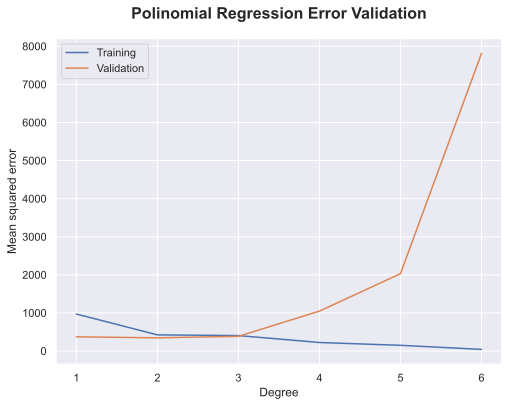

In [57]:
%%time
# Search the best degree and alpha
err_train_poly = []
err_val_poly_essen = []
alphas_poly_essen = []

for degree in range(1, 7):
    # Fit model
    poly = PolynomialFeatures(degree=degree)
    err_val = []
    X_poly_train = poly.fit_transform(X_essen_train)
    X_poly_val = poly.transform(X_essen_val)
    for alpha in np.arange(0, 50, 0.1):
        poly_reg_essen = Lasso(alpha=alpha)
        poly_model_essen = poly_reg_essen.fit(X_poly_train, y_essen_train)
        err_val.append(mean_squared_error(y_essen_val, poly_model_essen.predict(X_poly_val)))
    
    alphas_poly_essen.append(np.argmin(err_val)/10)
    poly_reg_essen = Lasso(alpha=np.argmin(err_val)/10)
    poly_model_essen = poly_reg_essen.fit(X_poly_train, y_essen_train)
    
    # Compute errors
    err_train_poly.append(mean_squared_error(y_essen_train, poly_model_essen.predict(X_poly_train)))
    err_val_poly_essen.append(mean_squared_error(y_essen_val, poly_model_essen.predict(X_poly_val)))
    
plt.figure(figsize=(8, 6))
plt.plot(range(1, 7), err_train_poly, range(1, 7), err_val_poly_essen)
plt.legend(["Training", "Validation"])
plt.xlabel("Degree")
plt.ylabel("Mean squared error")
plt.title("Polinomial Regression Error Validation", fontsize=16, fontweight="bold", pad=20)

In [58]:
alphas_poly_essen

[4.9, 1.6, 34.1, 32.6, 49.9, 49.9]

In [59]:
print("Best validation value for degree", np.argmin(err_val_poly_essen)+1, "and alpha", alphas_poly_essen[np.argmin(err_val_poly_essen)])

Best validation value for degree 2 and alpha 1.6


In [60]:
# Fit model (for the optimal degree and alpha)
poly = PolynomialFeatures(degree=np.argmin(err_val_poly_essen)+1)
X_poly_train = poly.fit_transform(X_essen_train)
X_poly_val = poly.transform(X_essen_val)
poly_reg_essen = Lasso(alpha=alphas_poly_essen[np.argmin(err_val_poly_essen)])
poly_model_essen = poly_reg_essen.fit(X_poly_train, y_essen_train)

# Predict
y_essen_pred_poly = poly_model_essen.predict(X_poly_val)

In [61]:
r2_essen.append(r2_score(y_essen_val, y_essen_pred_poly))
print("MSE:", mean_squared_error(y_essen_val, y_essen_pred_poly))
print("MAE:", mean_absolute_error(y_essen_val, y_essen_pred_poly))
print("R2: ", r2_score(y_essen_val, y_essen_pred_poly))

MSE: 346.02371032515833
MAE: 14.398124882285979
R2:  0.8184247535913796


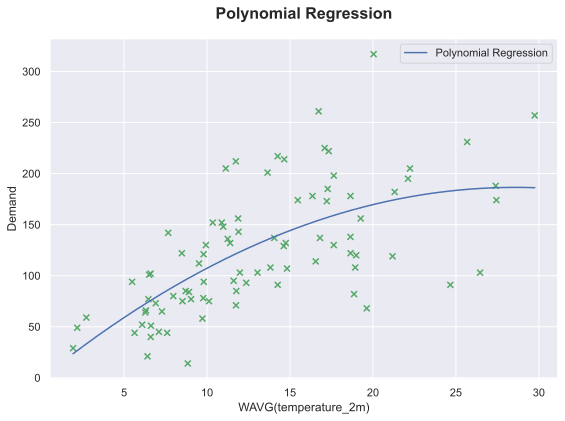

In [62]:
poly_feature = "WAVG(temperature_2m)"
poly = PolynomialFeatures(degree=np.argmin(err_val_poly_essen)+1)
X_poly_train = poly.fit_transform(X_essen_train[poly_feature].values.reshape(-1,1))

poly_essen = Lasso(alpha=alphas_poly_essen[np.argmin(err_val_poly_essen)]).fit(X_poly_train, y_essen_train)
plot_scikit_poly_output(X_essen_train[poly_feature], y_essen_train, poly_essen, poly, poly_feature, "Polynomial Regression", "Essen", "Polynomial Regression")

---

## Tree-Based Regression

### Bonn   
Which tree depth parameter $\mathrm{depth}$ is optimal?

Text(0.5, 1.0, 'Tree-Based Regression Error Validation')

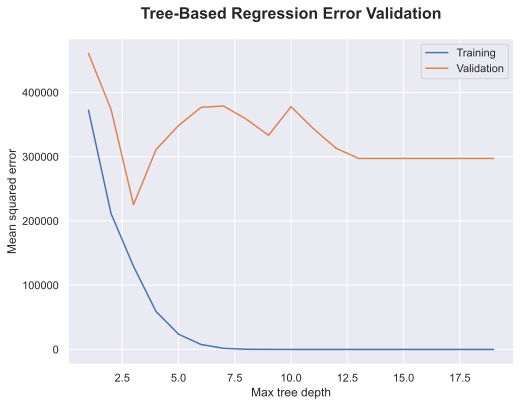

In [63]:
# Search the best tree depth
err_train_tree = []
err_val_tree = []

for depth in range(1, 20):
    # Fit model
    tree_reg_bonn = DecisionTreeRegressor(max_depth=depth, criterion="mse", random_state=42)
    tree_model_bonn = tree_reg_bonn.fit(X_bonn_train, y_bonn_train)
    
    # Compute errors
    err_train_tree.append(mean_squared_error(y_bonn_train, tree_model_bonn.predict(X_bonn_train)))
    err_val_tree.append(mean_squared_error(y_bonn_val, tree_model_bonn.predict(X_bonn_val)))
    
plt.figure(figsize=(8, 6))
plt.plot(range(1, 20), err_train_tree, range(1, 20), err_val_tree)
plt.legend(["Training", "Validation"])
plt.xlabel("Max tree depth")
plt.ylabel("Mean squared error")
plt.title("Tree-Based Regression Error Validation", fontsize=16, fontweight="bold", pad=20)

In [64]:
print("Best validation value for", np.argmin(err_val_tree)+1, "max depth")

Best validation value for 3 max depth


Train model with the optimal $\mathrm{depth}$.

In [65]:
# Fit model (for the optimal tree depth)
tree_reg_bonn = DecisionTreeRegressor(max_depth=np.argmin(err_val_tree)+1, criterion="mse", random_state=42)
tree_model_bonn = tree_reg_bonn.fit(X_bonn_train, y_bonn_train)

# Predict
y_bonn_pred_tree = tree_model_bonn.predict(X_bonn_val)

In [66]:
r2_bonn.append(r2_score(y_bonn_val, y_bonn_pred_tree))
print("MSE:", mean_squared_error(y_bonn_val, y_bonn_pred_tree))
print("MAE:", mean_absolute_error(y_bonn_val, y_bonn_pred_tree))
print("R2: ", r2_score(y_bonn_val, y_bonn_pred_tree))

MSE: 225358.2033513784
MAE: 310.14331417624516
R2:  0.697152721461312


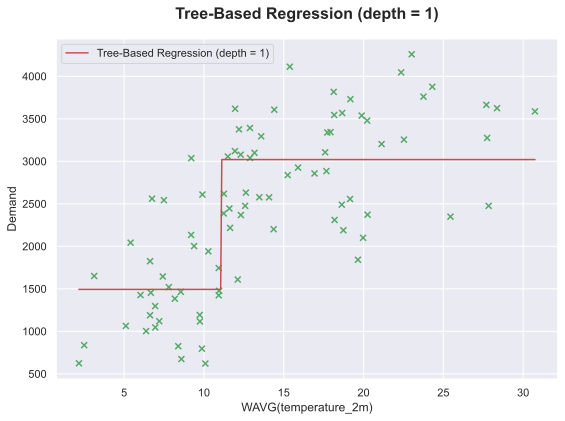

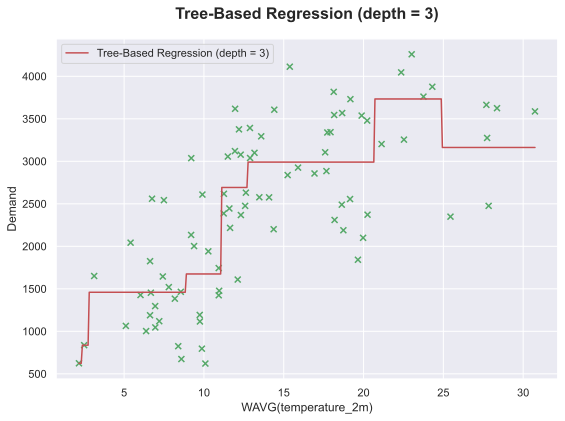

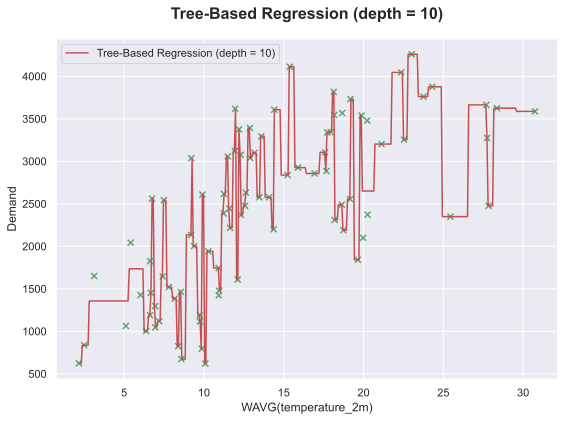

In [67]:
tree_feature = "WAVG(temperature_2m)"
for depth in (1, np.argmin(err_val_tree)+1, 10):
    tree_reg_bonn = DecisionTreeRegressor(max_depth=depth, criterion="mse", random_state=42)
    tree_model_bonn = tree_reg_bonn.fit(X_bonn_train[tree_feature].values.reshape(-1, 1), y_bonn_train)
    plot_scikit_output(X_bonn_train[tree_feature], 
                       y_bonn_train, 
                       tree_model_bonn, 
                       tree_feature, 
                       f"Tree-Based Regression (depth = {depth})", 
                       "Bonn", 
                       f"Tree-Based Regression (depth = {depth})")

In [68]:
def plot_regression_tree_sklearn(tree_depth, city):
    
    if city == "Bonn":
        X = X_bonn_train
        y = y_bonn_train
    else:
        X = X_essen_train
        y = y_essen_train

    # Fit regression model
    model = DecisionTreeRegressor(max_depth=tree_depth, criterion="mse", random_state=42)
    model.fit(X[tree_feature].values.reshape(-1, 1), y) 
    
    dot_data = export_graphviz(model, feature_names=["WAVG(temperature_2m)"], filled=True, rounded=True)  
    
    graph = graphviz.Source(dot_data) 
    
    return graph

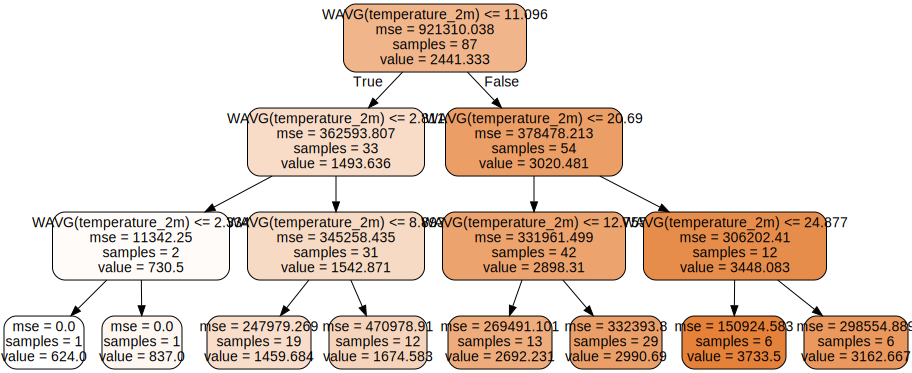

In [169]:
plot_regression_tree_sklearn(np.argmin(err_val_tree)+1, city="Bonn")

### Essen   
Which tree depth parameter $\mathrm{depth}$ is optimal?

Text(0.5, 1.0, 'Tree-Based Regression Error Validation')

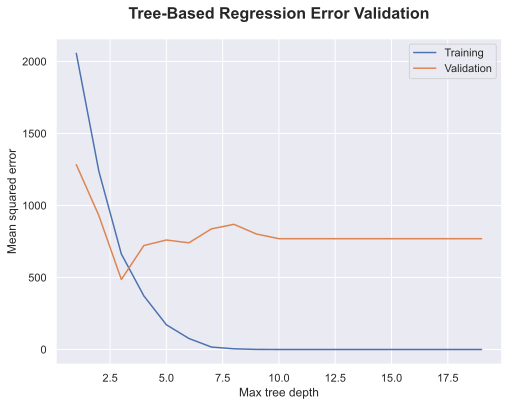

In [70]:
# Search the best tree depth
err_train_tree = []
err_val_tree = []

for depth in range(1, 20):
    # Fit model
    tree_reg_essen = DecisionTreeRegressor(max_depth=depth, criterion="mse", random_state=42)
    tree_model_essen = tree_reg_essen.fit(X_essen_train, y_essen_train)
    
    # Compute errors
    err_train_tree.append(mean_squared_error(y_essen_train, tree_model_essen.predict(X_essen_train)))
    err_val_tree.append(mean_squared_error(y_essen_val, tree_model_essen.predict(X_essen_val)))
    
plt.figure(figsize=(8, 6))
plt.plot(range(1, 20), err_train_tree, range(1, 20), err_val_tree)
plt.legend(["Training", "Validation"])
plt.xlabel("Max tree depth")
plt.ylabel("Mean squared error")
plt.title("Tree-Based Regression Error Validation", fontsize=16, fontweight="bold", pad=20)

In [71]:
print("Best validation value for", np.argmin(err_val_tree)+1, "max depth")

Best validation value for 3 max depth


Train model with the optimal $\mathrm{depth}$.

In [72]:
# Fit model (for the optimal tree depth)
tree_reg_essen = DecisionTreeRegressor(max_depth=np.argmin(err_val_tree)+1, criterion="mse", random_state=42)
tree_model_essen = tree_reg_essen.fit(X_essen_train, y_essen_train)

# Predict
y_essen_pred_tree = tree_model_essen.predict(X_essen_val)

In [73]:
r2_essen.append(r2_score(y_essen_val, y_essen_pred_tree))
print("MSE:", mean_squared_error(y_essen_val, y_essen_pred_tree))
print("MAE:", mean_absolute_error(y_essen_val, y_essen_pred_tree))
print("R2: ", r2_score(y_essen_val, y_essen_pred_tree))

MSE: 486.22838531979244
MAE: 18.563812308549153
R2:  0.7448526322304803


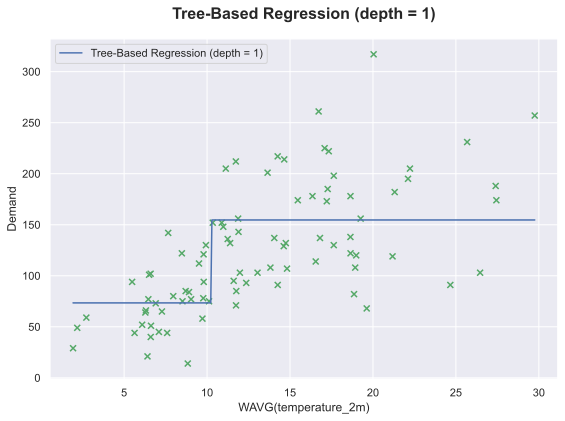

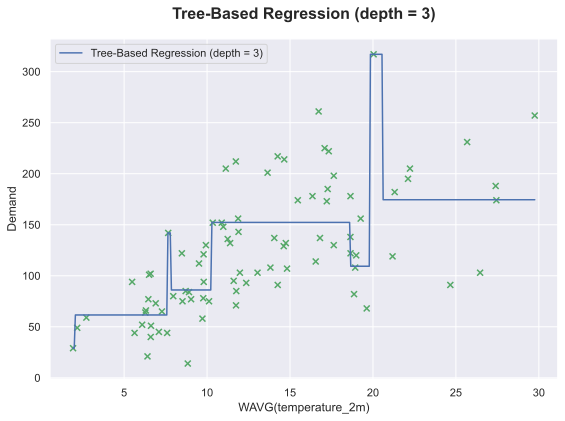

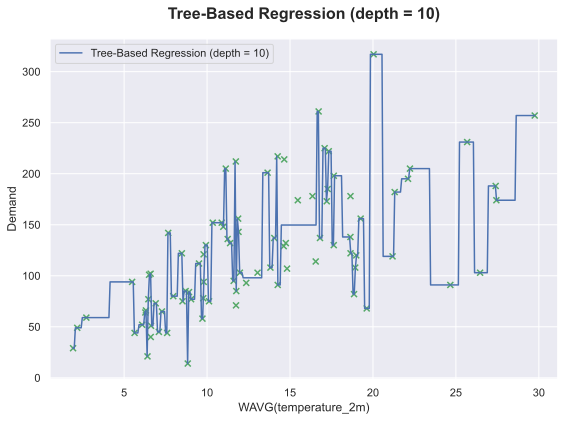

In [74]:
tree_feature = "WAVG(temperature_2m)"
for depth in (1, np.argmin(err_val_tree)+1, 10):
    tree_reg_essen = DecisionTreeRegressor(max_depth=depth, criterion="mse", random_state=42)
    tree_model_essen = tree_reg_essen.fit(X_essen_train[tree_feature].values.reshape(-1, 1), y_essen_train)
    plot_scikit_output(X_essen_train[tree_feature], 
                       y_essen_train, 
                       tree_model_essen, 
                       tree_feature, 
                       f"Tree-Based Regression (depth = {depth})", 
                       "Essen", 
                       f"Tree-Based Regression (depth = {depth})")

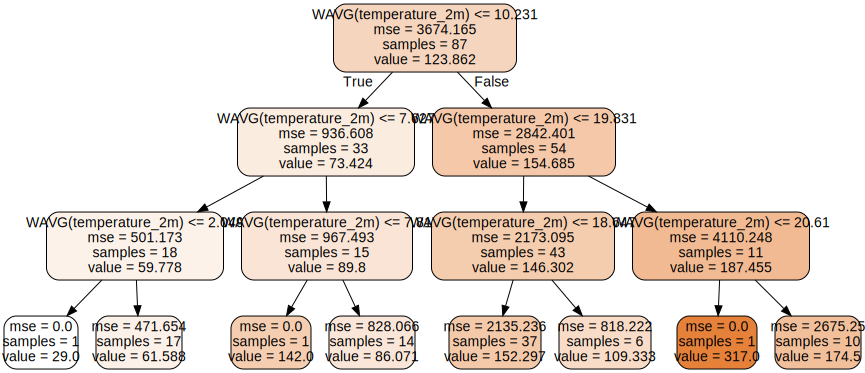

In [170]:
plot_regression_tree_sklearn(np.argmin(err_val_tree)+1, city="Essen")

---

## Boosting   
Let's test some boosting techniques.

### AdaBoost

#### Bonn

In [76]:
ada_bonn = AdaBoostRegressor(random_state=42)
ada_bonn.fit(X_bonn_train, y_bonn_train)
y_bonn_predict_ada = ada_bonn.predict(X_bonn_val)

In [77]:
r2_bonn.append(r2_score(y_bonn_val, y_bonn_predict_ada))
print("MSE:", mean_squared_error(y_bonn_val, y_bonn_predict_ada))
print("MAE:", mean_absolute_error(y_bonn_val, y_bonn_predict_ada))
print("R2: ", r2_score(y_bonn_val, y_bonn_predict_ada))

MSE: 115339.10299499655
MAE: 269.977189051689
R2:  0.8450017220066975


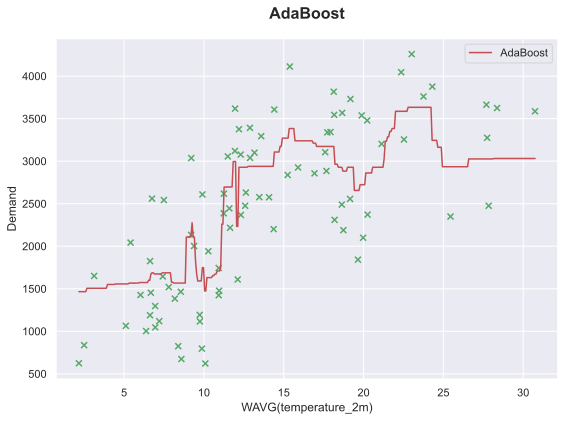

In [78]:
ada_feature = "WAVG(temperature_2m)"
ada_bonn = AdaBoostRegressor(random_state=42).fit(X_bonn_train[ada_feature].values.reshape(-1, 1), y_bonn_train)
plot_scikit_output(X_bonn_train[ada_feature], 
                   y_bonn_train, 
                   ada_bonn, 
                   ada_feature, 
                   "AdaBoost", "Bonn", "AdaBoost")

#### Essen

In [79]:
ada_essen = AdaBoostRegressor(random_state=42)
ada_essen.fit(X_essen_train, y_essen_train)
y_essen_predict_ada = ada_essen.predict(X_essen_val)

In [80]:
r2_essen.append(r2_score(y_essen_val, y_essen_predict_ada))
print("MSE:", mean_squared_error(y_essen_val, y_essen_predict_ada))
print("MAE:", mean_absolute_error(y_essen_val, y_essen_predict_ada))
print("R2: ", r2_score(y_essen_val, y_essen_predict_ada))

MSE: 415.2019660805194
MAE: 15.211144750220654
R2:  0.7821236029474118


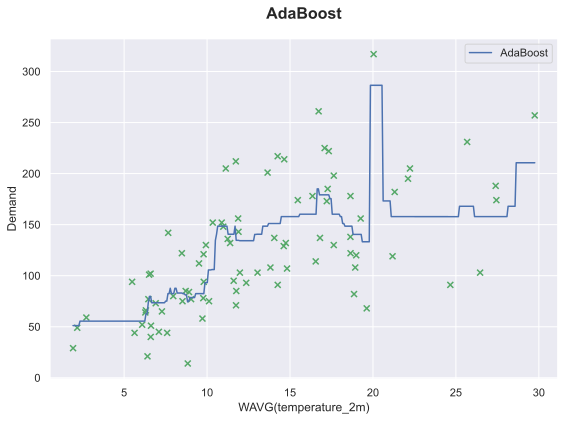

In [81]:
ada_feature = "WAVG(temperature_2m)"
ada_essen = AdaBoostRegressor(random_state=42).fit(X_essen_train[ada_feature].values.reshape(-1, 1), y_essen_train)
plot_scikit_output(X_essen_train[ada_feature], 
                   y_essen_train, 
                   ada_essen, 
                   ada_feature, 
                   "AdaBoost", "Essen", "AdaBoost")

---

### Gradient Tree Boosting

#### Bonn

In [82]:
gradient_bonn = GradientBoostingRegressor(random_state=42)
gradient_bonn.fit(X_bonn_train, y_bonn_train)
y_bonn_predict_gradient = gradient_bonn.predict(X_bonn_val)

In [83]:
r2_bonn.append(r2_score(y_bonn_val, y_bonn_predict_gradient))
print("MSE:", mean_squared_error(y_bonn_val, y_bonn_predict_gradient))
print("MAE:", mean_absolute_error(y_bonn_val, y_bonn_predict_gradient))
print("R2: ", r2_score(y_bonn_val, y_bonn_predict_gradient))

MSE: 98521.54806164543
MAE: 215.01822291837706
R2:  0.867601967604587


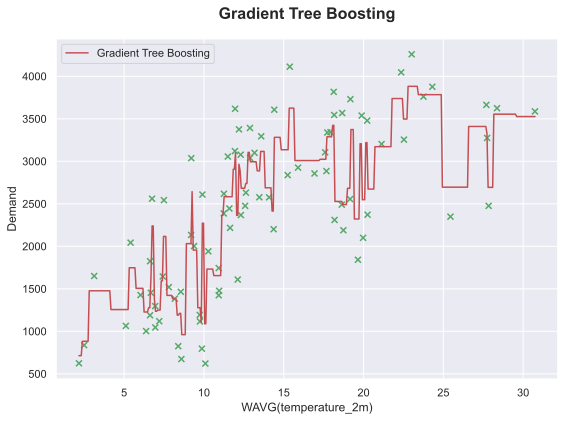

In [84]:
gradient_feature = "WAVG(temperature_2m)"
gradient_bonn = GradientBoostingRegressor(random_state=42).fit(X_bonn_train[gradient_feature].values.reshape(-1, 1), 
                                                              y_bonn_train)
plot_scikit_output(X_bonn_train[gradient_feature], 
                   y_bonn_train, 
                   gradient_bonn, 
                   gradient_feature, 
                   "Gradient Tree Boosting", "Bonn", "Gradient Tree Boosting")

#### Essen

In [85]:
gradient_essen = GradientBoostingRegressor(random_state=42)
gradient_essen.fit(X_essen_train, y_essen_train)
y_essen_predict_gradient = gradient_essen.predict(X_essen_val)

In [86]:
r2_essen.append(r2_score(y_essen_val, y_essen_predict_gradient))
print("MSE:", mean_squared_error(y_essen_val, y_essen_predict_gradient))
print("MAE:", mean_absolute_error(y_essen_val, y_essen_predict_gradient))
print("R2: ", r2_score(y_essen_val, y_essen_predict_gradient))

MSE: 323.08742788256797
MAE: 14.508696711866897
R2:  0.8304605216961073


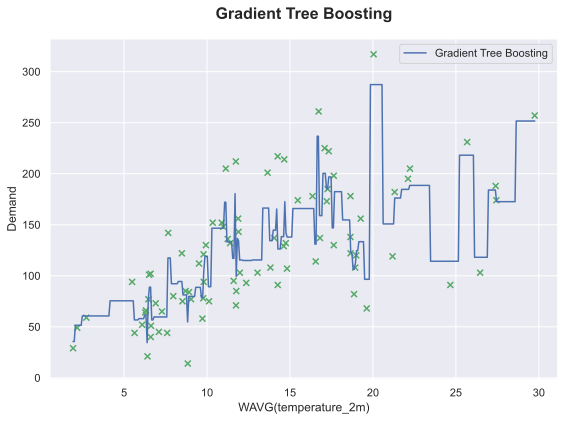

In [87]:
gradient_feature = "WAVG(temperature_2m)"
gradient_essen = GradientBoostingRegressor(random_state=42).fit(X_essen_train[gradient_feature].values.reshape(-1, 1), 
                                                               y_essen_train)
plot_scikit_output(X_essen_train[gradient_feature], 
                   y_essen_train, 
                   gradient_essen, 
                   gradient_feature, 
                   "Gradient Tree Boosting", "Essen", "Gradient Tree Boosting")

---

### XGBoost

#### Bonn

Text(0.5, 1.0, 'XGBoost Error Validation')

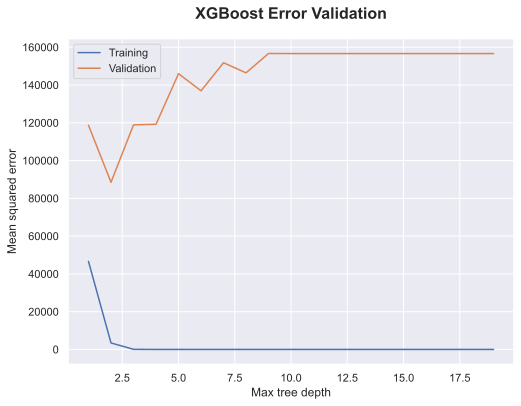

In [88]:
err_train_xg_bonn = []
err_val_xg_bonn = []

for depth in range(1, 20):
    # Fit model
    xg_regressor = xgb.XGBRegressor(max_depth = depth, random_state=42)
    xg_model = xg_regressor.fit(X_bonn_train, y_bonn_train)
    
    # Compute errors
    err_train_xg_bonn.append(mean_squared_error(y_bonn_train, xg_model.predict(X_bonn_train)))
    err_val_xg_bonn.append(mean_squared_error(y_bonn_val, xg_model.predict(X_bonn_val)))
    
plt.figure(figsize=(8, 6))
plt.plot(range(1, 20), err_train_xg_bonn, range(1, 20), err_val_xg_bonn)
plt.legend(["Training", "Validation"])
plt.xlabel("Max tree depth")
plt.ylabel("Mean squared error")
plt.title("XGBoost Error Validation", fontsize=16, fontweight="bold", pad=20)

In [89]:
print("Best validation value for", np.argmin(err_val_xg_bonn)+1, "max depth")

Best validation value for 2 max depth


In [90]:
xg_reg_bonn = xgb.XGBRegressor(max_depth = np.argmin(err_val_xg_bonn)+1, random_state=42)
xg_reg_bonn.fit(X_bonn_train, y_bonn_train)

y_bonn_predict_xg = xg_reg_bonn.predict(X_bonn_val)

In [91]:
r2_bonn.append(r2_score(y_bonn_val, y_bonn_predict_xg))
print("MSE:", mean_squared_error(y_bonn_val, y_bonn_predict_xg))
print("MAE:", mean_absolute_error(y_bonn_val, y_bonn_predict_xg))
print("R2: ", r2_score(y_bonn_val, y_bonn_predict_xg))

MSE: 88506.60793370195
MAE: 222.2678202311198
R2:  0.8810605296510129


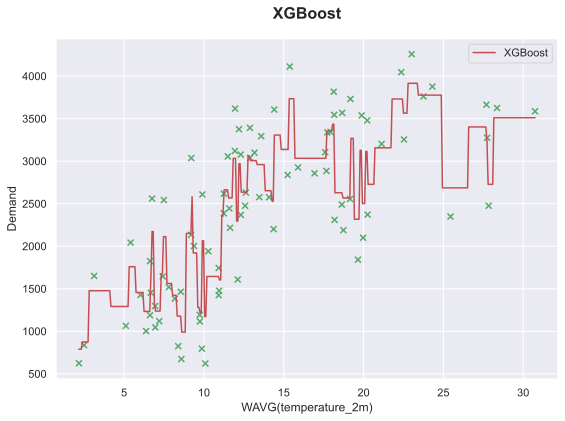

In [92]:
xg_feature = "WAVG(temperature_2m)"
xg_bonn = xgb.XGBRegressor(max_depth = np.argmin(err_val_xg_bonn)+1, random_state=42).fit(X_bonn_train[xg_feature].values.reshape(-1, 1), 
                                 y_bonn_train)
plot_scikit_output(X_bonn_train[xg_feature], 
                   y_bonn_train, 
                   xg_bonn, 
                   xg_feature, 
                   "XGBoost", "Bonn", "XGBoost")

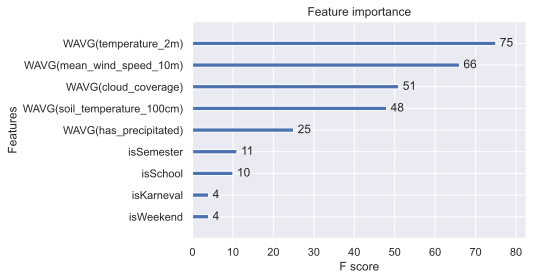

In [93]:
xgb.plot_importance(xg_reg_bonn)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()

#### Essen

Text(0.5, 1.0, 'XGBoost Error Validation')

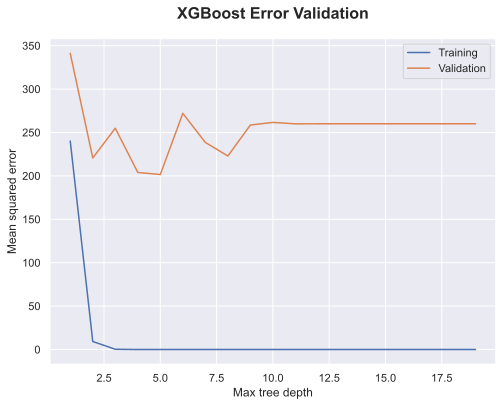

In [94]:
err_train_xg_essen = []
err_val_xg_essen = []

for depth in range(1, 20):
    # Fit model
    xg_regressor = xgb.XGBRegressor(max_depth = depth, random_state=42)
    xg_model = xg_regressor.fit(X_essen_train, y_essen_train)
    
    # Compute errors
    err_train_xg_essen.append(mean_squared_error(y_essen_train, xg_model.predict(X_essen_train)))
    err_val_xg_essen.append(mean_squared_error(y_essen_val, xg_model.predict(X_essen_val)))
    
plt.figure(figsize=(8, 6))
plt.plot(range(1, 20), err_train_xg_essen, range(1, 20), err_val_xg_essen)
plt.legend(["Training", "Validation"])
plt.xlabel("Max tree depth")
plt.ylabel("Mean squared error")
plt.title("XGBoost Error Validation", fontsize=16, fontweight="bold", pad=20)

In [95]:
print("Best validation value for", np.argmin(err_val_xg_essen)+1, "max depth")

Best validation value for 5 max depth


In [96]:
xg_reg_essen = xgb.XGBRegressor(max_depth = np.argmin(err_val_xg_essen)+1, random_state=42)
xg_reg_essen.fit(X_essen_train,y_essen_train)

y_essen_predict_xg = xg_reg_essen.predict(X_essen_val)

In [97]:
r2_essen.append(r2_score(y_essen_val, y_essen_predict_xg))
print("MSE:", mean_squared_error(y_essen_val, y_essen_predict_xg))
print("MAE:", mean_absolute_error(y_essen_val, y_essen_predict_xg))
print("R2: ", r2_score(y_essen_val, y_essen_predict_xg))

MSE: 201.58020278488027
MAE: 11.733221117655436
R2:  0.8942211938096108


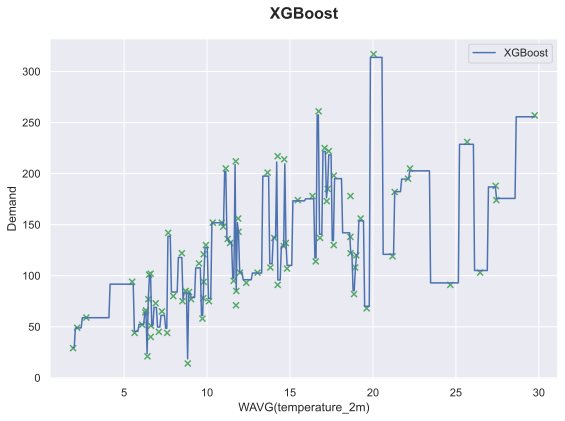

In [98]:
xg_feature = "WAVG(temperature_2m)"
xg_essen = xgb.XGBRegressor(max_depth = np.argmin(err_val_xg_essen)+1, random_state=42).fit(X_essen_train[xg_feature].values.reshape(-1, 1), 
                                                                           y_essen_train)
plot_scikit_output(X_essen_train[xg_feature], 
                   y_essen_train, 
                   xg_essen, 
                   xg_feature, 
                   "XGBoost", "Essen", "XGBoost")

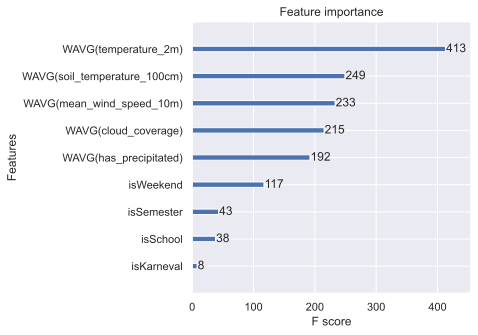

In [99]:
xgb.plot_importance(xg_reg_essen)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()

---

## Bagging

### Bonn

Text(0.5, 1.0, 'Bagging Error Validation')

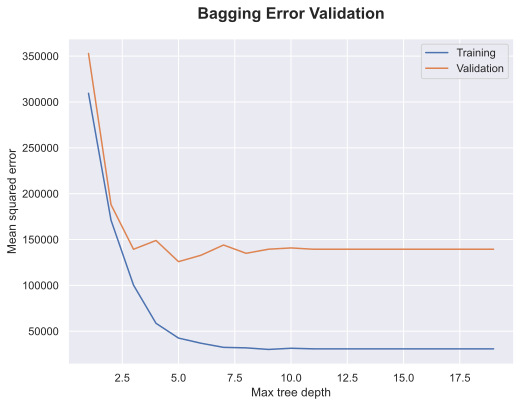

In [100]:
err_train_bagging_bonn = []
err_val_bagging_bonn = []

for depth in range(1, 20):
    # Fit model
    bagging_regressor = BaggingRegressor(base_estimator=DecisionTreeRegressor(max_depth=depth, 
                                                                              criterion="mse", 
                                                                              random_state=42), 
                                         random_state=42)
    bagging_model = bagging_regressor.fit(X_bonn_train, y_bonn_train)
    
    # Compute errors
    err_train_bagging_bonn.append(mean_squared_error(y_bonn_train, bagging_model.predict(X_bonn_train)))
    err_val_bagging_bonn.append(mean_squared_error(y_bonn_val, bagging_model.predict(X_bonn_val)))
    
plt.figure(figsize=(8, 6))
plt.plot(range(1, 20), err_train_bagging_bonn, range(1, 20), err_val_bagging_bonn)
plt.legend(["Training", "Validation"])
plt.xlabel("Max tree depth")
plt.ylabel("Mean squared error")
plt.title("Bagging Error Validation", fontsize=16, fontweight="bold", pad=20)

In [101]:
print("Best validation value for", np.argmin(err_val_bagging_bonn)+1, "max depth")

Best validation value for 5 max depth


In [102]:
bagging_bonn = BaggingRegressor(base_estimator=DecisionTreeRegressor(max_depth=np.argmin(err_val_bagging_bonn)+1,
                                                                     criterion="mse", 
                                                                     random_state=42), 
                                 random_state=42)
bagging_bonn.fit(X_bonn_train, y_bonn_train)
y_bonn_predict_bagging = bagging_bonn.predict(X_bonn_val)

In [103]:
r2_bonn.append(r2_score(y_bonn_val, y_bonn_predict_bagging))
print("MSE:", mean_squared_error(y_bonn_val, y_bonn_predict_bagging))
print("MAE:", mean_absolute_error(y_bonn_val, y_bonn_predict_bagging))
print("R2: ", r2_score(y_bonn_val, y_bonn_predict_bagging))

MSE: 125859.18172629182
MAE: 267.4068212805712
R2:  0.8308643302170677


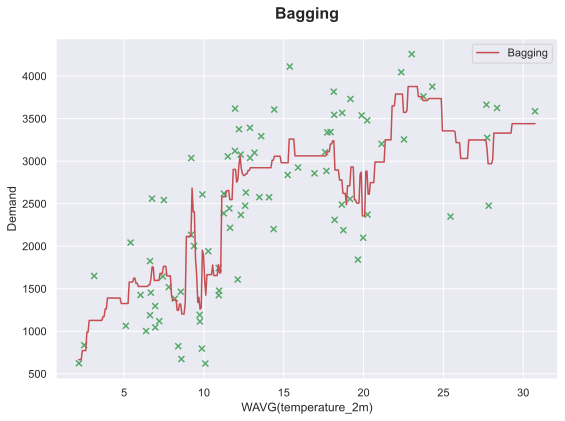

In [104]:
bagging_feature = "WAVG(temperature_2m)"
bagging_bonn = BaggingRegressor(base_estimator=DecisionTreeRegressor(max_depth=np.argmin(err_val_bagging_bonn)+1, 
                                                                     criterion="mse", 
                                                                     random_state=42), 
                                random_state=42).fit(X_bonn_train[bagging_feature].values.reshape(-1, 1), 
                                                    y_bonn_train)
plot_scikit_output(X_bonn_train[bagging_feature], 
                   y_bonn_train, 
                   bagging_bonn, 
                   bagging_feature, 
                   "Bagging", "Bonn", "Bagging")

### Essen

Text(0.5, 1.0, 'Bagging Error Validation')

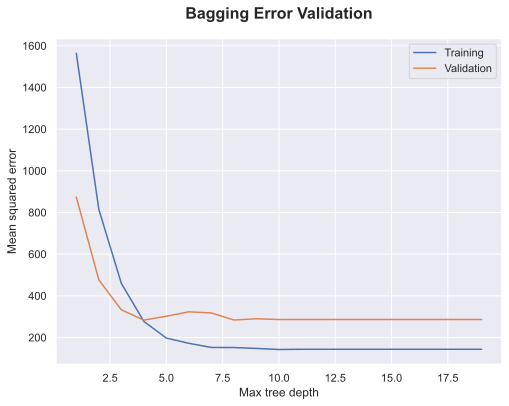

In [105]:
err_train_bagging_essen = []
err_val_bagging_essen = []

for depth in range(1, 20):
    # Fit model
    bagging_regressor = BaggingRegressor(base_estimator=DecisionTreeRegressor(max_depth=depth, 
                                                                              criterion="mse", 
                                                                              random_state=42), 
                                         random_state=42)
    bagging_model = bagging_regressor.fit(X_essen_train, y_essen_train)
    
    # Compute errors
    err_train_bagging_essen.append(mean_squared_error(y_essen_train, bagging_model.predict(X_essen_train)))
    err_val_bagging_essen.append(mean_squared_error(y_essen_val, bagging_model.predict(X_essen_val)))
    
plt.figure(figsize=(8, 6))
plt.plot(range(1, 20), err_train_bagging_essen, range(1, 20), err_val_bagging_essen)
plt.legend(["Training", "Validation"])
plt.xlabel("Max tree depth")
plt.ylabel("Mean squared error")
plt.title("Bagging Error Validation", fontsize=16, fontweight="bold", pad=20)

In [106]:
print("Best validation value for", np.argmin(err_val_bagging_essen)+1, "max depth")

Best validation value for 4 max depth


In [107]:
bagging_essen =  BaggingRegressor(base_estimator=DecisionTreeRegressor(max_depth=np.argmin(err_val_bagging_essen)+1,
                                                                       criterion="mse", 
                                                                       random_state=42), 
                              random_state=42)
bagging_essen.fit(X_essen_train, y_essen_train)
y_essen_predict_bagging = bagging_essen.predict(X_essen_val)

In [108]:
r2_essen.append(r2_score(y_essen_val, y_essen_predict_bagging))
print("MSE:", mean_squared_error(y_essen_val, y_essen_predict_bagging))
print("MAE:", mean_absolute_error(y_essen_val, y_essen_predict_bagging))
print("R2: ", r2_score(y_essen_val, y_essen_predict_bagging))

MSE: 283.4326092285399
MAE: 13.54564502439425
R2:  0.851269308069816


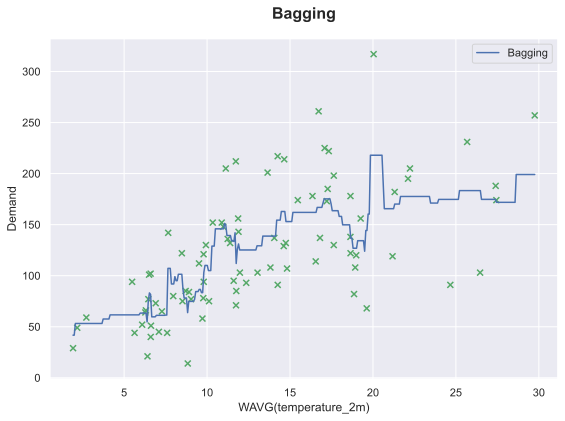

In [109]:
bagging_feature = "WAVG(temperature_2m)"
bagging_essen = BaggingRegressor(base_estimator=DecisionTreeRegressor(max_depth=np.argmin(err_val_bagging_essen)+1,
                                                                      criterion="mse", 
                                                                      random_state=42), 
                                random_state=42).fit(X_essen_train[bagging_feature].values.reshape(-1, 1), 
                                                    y_essen_train)
plot_scikit_output(X_essen_train[bagging_feature], 
                   y_essen_train, 
                   bagging_essen, 
                   bagging_feature, 
                   "Bagging", "Essen", "Bagging")

---

## Random Forest

### Bonn

Text(0.5, 1.0, 'Random Forest Error Validation')

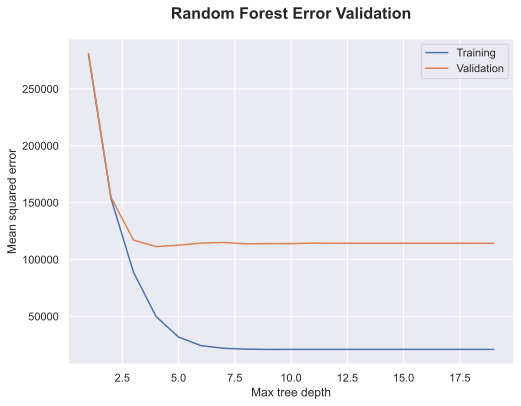

In [110]:
err_train_rf_bonn = []
err_val_rf_bonn = []

for depth in range(1, 20):
    # Fit model
    rf_regressor = RandomForestRegressor(n_estimators=1000, 
                                         bootstrap=True, # we select boostrapp, i.e. we use bagging
                                         random_state=42,
                                         max_depth=depth,
                                         criterion="mse") 
    rf_model = rf_regressor.fit(X_bonn_train, y_bonn_train)
    
    # Compute errors
    err_train_rf_bonn.append(mean_squared_error(y_bonn_train, rf_model.predict(X_bonn_train)))
    err_val_rf_bonn.append(mean_squared_error(y_bonn_val, rf_model.predict(X_bonn_val)))
    
plt.figure(figsize=(8, 6))
plt.plot(range(1, 20), err_train_rf_bonn, range(1, 20), err_val_rf_bonn)
plt.legend(["Training", "Validation"])
plt.xlabel("Max tree depth")
plt.ylabel("Mean squared error")
plt.title("Random Forest Error Validation", fontsize=16, fontweight="bold", pad=20)

In [111]:
print("Best validation value for", np.argmin(err_val_rf_bonn)+1, "max depth")

Best validation value for 4 max depth


In [112]:
# sepcify and fit model

rf_regressor_bonn = RandomForestRegressor(n_estimators=1000, 
                                          bootstrap=True, # we select boostrapp, i.e. we use bagging
                                          random_state=42,
                                          max_depth=np.argmin(err_val_rf_bonn)+1,
                                          criterion="mse") 
rf_model_bonn = rf_regressor_bonn.fit(X_bonn_train, y_bonn_train)
y_bonn_predict_rf = rf_model_bonn.predict(X_bonn_val)

In [113]:
r2_bonn.append(r2_score(y_bonn_val, y_bonn_predict_rf))
print("MSE:", mean_squared_error(y_bonn_val, y_bonn_predict_rf))
print("MAE:", mean_absolute_error(y_bonn_val, y_bonn_predict_rf))
print("R2: ", r2_score(y_bonn_val, y_bonn_predict_rf))

MSE: 111398.94115418046
MAE: 259.92860881122726
R2:  0.8502967024988547


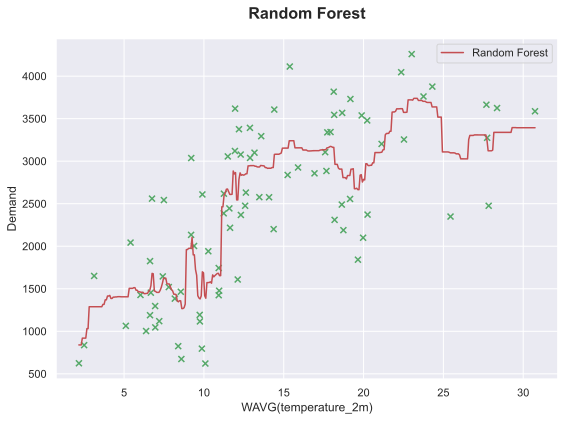

In [114]:
rf_feature = "WAVG(temperature_2m)"
rf_model_bonn = RandomForestRegressor(n_estimators=1000, 
                                      bootstrap=True, # we select boostrapp, i.e. we use bagging
                                      random_state=42,
                                      max_depth=np.argmin(err_val_rf_bonn)+1,
                                      criterion="mse").fit(X_bonn_train[rf_feature].values.reshape(-1, 1), 
                                                           y_bonn_train)
plot_scikit_output(X_bonn_train[rf_feature], 
                   y_bonn_train, 
                   rf_model_bonn, 
                   rf_feature, 
                   "Random Forest", 
                   "Bonn", 
                   "Random Forest")

### Essen

Text(0.5, 1.0, 'Random Forest Error Validation')

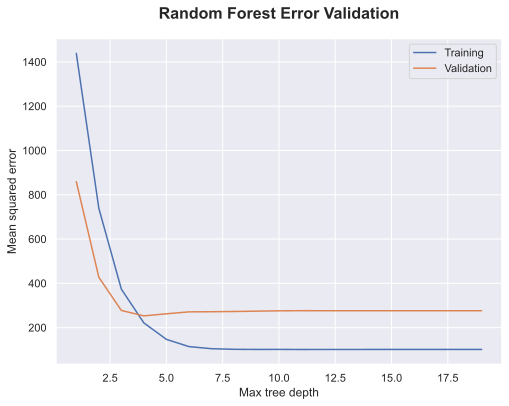

In [115]:
err_train_rf_essen = []
err_val_rf_essen = []

for depth in range(1, 20):
    # Fit model
    rf_regressor = RandomForestRegressor(n_estimators=1000, 
                                         bootstrap=True, # we select boostrapp, i.e. we use bagging
                                         random_state=42,
                                         max_depth=depth,
                                         criterion="mse") 
    rf_model = rf_regressor.fit(X_essen_train, y_essen_train)
    
    # Compute errors
    err_train_rf_essen.append(mean_squared_error(y_essen_train, rf_model.predict(X_essen_train)))
    err_val_rf_essen.append(mean_squared_error(y_essen_val, rf_model.predict(X_essen_val)))
    
plt.figure(figsize=(8, 6))
plt.plot(range(1, 20), err_train_rf_essen, range(1, 20), err_val_rf_essen)
plt.legend(["Training", "Validation"])
plt.xlabel("Max tree depth")
plt.ylabel("Mean squared error")
plt.title("Random Forest Error Validation", fontsize=16, fontweight="bold", pad=20)

In [116]:
print("Best validation value for", np.argmin(err_val_rf_essen)+1, "max depth")

Best validation value for 4 max depth


In [117]:
# sepcify and fit model

rf_regressor_essen = RandomForestRegressor(n_estimators=1000, 
                                           bootstrap=True, # we select boostrapp, i.e. we use bagging
                                           random_state=42,
                                           max_depth=np.argmin(err_val_rf_essen)+1,
                                           criterion="mse") 
rf_model_essen = rf_regressor_essen.fit(X_essen_train, y_essen_train)
y_essen_predict_rf = rf_model_essen.predict(X_essen_val)

In [118]:
r2_essen.append(r2_score(y_essen_val, y_essen_predict_rf))
print("MSE:", mean_squared_error(y_essen_val, y_essen_predict_rf))
print("MAE:", mean_absolute_error(y_essen_val, y_essen_predict_rf))
print("R2: ", r2_score(y_essen_val, y_essen_predict_rf))

MSE: 253.02334811516124
MAE: 12.139217795723965
R2:  0.867226506709693


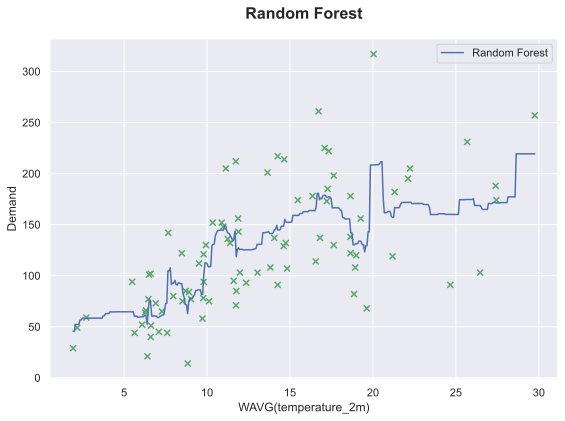

In [119]:
rf_feature = "WAVG(temperature_2m)"
rf_model_essen = RandomForestRegressor(n_estimators=1000, 
                                       bootstrap=True, # we select boostrapp, i.e. we use bagging
                                       random_state=1,
                                       max_depth=np.argmin(err_val_rf_essen)+1, 
                                       criterion="mse").fit(X_essen_train[rf_feature].values.reshape(-1, 1), 
                                                           y_essen_train)
plot_scikit_output(X_essen_train[rf_feature], 
                   y_essen_train, 
                   rf_model_essen, 
                   rf_feature, 
                   "Random Forest", 
                   "Essen", 
                   "Random Forest")

---

## RBF Regression

### Bonn

CPU times: user 20.1 s, sys: 250 ms, total: 20.3 s
Wall time: 20.6 s


Text(0.5, 1.0, 'RBF Regression Error Validation')

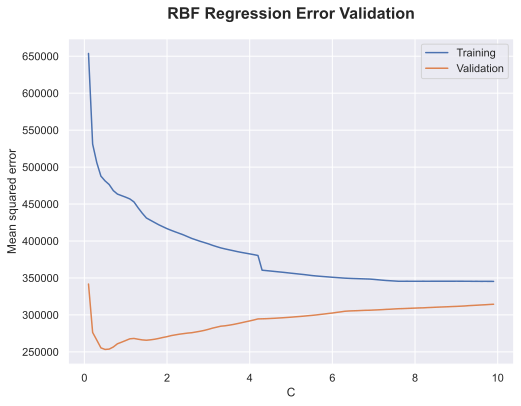

In [120]:
%%time
# Search the best degree and gamma
err_train_rbf = []
err_val_rbf = []
gammas = []
sc_X = StandardScaler()
sc_y = StandardScaler()
X_bonn_train_sc = sc_X.fit_transform(X_bonn_train)
y_bonn_train_sc = sc_y.fit_transform(y_bonn_train.values.reshape(-1, 1))
X_bonn_val_sc = sc_X.fit_transform(X_bonn_val)
y_bonn_val_sc = sc_y.fit_transform(y_bonn_val.values.reshape(-1, 1))
    
for C in np.arange(0.1, 10, 0.1):
    # Fit model
    err_val = []
    for gamma in np.arange(0.1, 10, 0.1):
        rbf_regressor_bonn = SVR(kernel='rbf', gamma=gamma, C=C)
        rbf_model_bonn = rbf_regressor_bonn.fit(X_bonn_train_sc, y_bonn_train_sc)
        err_val.append(mean_squared_error(y_bonn_val, sc_y.inverse_transform(rbf_model_bonn.predict(X_bonn_val_sc))))
    
    gammas.append(np.argmin(err_val)/10)
    rbf_reg_bonn = SVR(kernel='rbf', C=C, gamma=np.argmin(err_val)/10+0.1)
    rbf_model_bonn = rbf_reg_bonn.fit(X_bonn_train_sc, y_bonn_train_sc)
    
    # Compute errors
    err_train_rbf.append(mean_squared_error(y_bonn_train, sc_y.inverse_transform(rbf_model_bonn.predict(X_bonn_train_sc))))
    err_val_rbf.append(mean_squared_error(y_bonn_val, sc_y.inverse_transform(rbf_model_bonn.predict(X_bonn_val_sc))))
    
plt.figure(figsize=(8, 6))
plt.plot(np.arange(0.1, 10, 0.1), err_train_rbf, np.arange(0.1, 10, 0.1), err_val_rbf)
plt.legend(["Training", "Validation"])
plt.xlabel("C")
plt.ylabel("Mean squared error")
plt.title("RBF Regression Error Validation", fontsize=16, fontweight="bold", pad=20)

In [121]:
print("Best validation value for C", np.argmin(err_val_rbf)/10+0.1, "and gamma", gammas[np.argmin(err_val_rbf)]+0.1)

Best validation value for C 0.5 and gamma 0.1


In [122]:
# Fit model (for the optimal C and gamma)
rbf_reg_bonn = SVR(kernel='rbf', gamma=gammas[np.argmin(err_val_rbf)]+0.1, C=np.argmin(err_val_rbf)/10+0.1)
rbf_model_bonn = rbf_reg_bonn.fit(X_bonn_train_sc, y_bonn_train_sc)

# Predict
y_bonn_pred_rbf = sc_y.inverse_transform(rbf_model_bonn.predict(X_bonn_val_sc))

In [123]:
r2_bonn.append(r2_score(y_bonn_val, y_bonn_pred_rbf))
print("MSE:", mean_squared_error(y_bonn_val, y_bonn_pred_rbf))
print("MAE:", mean_absolute_error(y_bonn_val, y_bonn_pred_rbf))
print("R2: ", r2_score(y_bonn_val, y_bonn_pred_rbf))

MSE: 253304.23291871682
MAE: 377.367705062712
R2:  0.6595974921660464


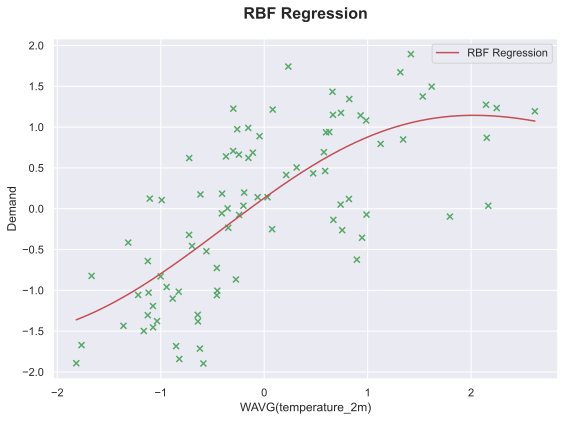

In [124]:
rbf_feature = "WAVG(temperature_2m)"
rbf_regressor_bonn = SVR(kernel='rbf', gamma=gammas[np.argmin(err_val_rbf)]+0.1, C=np.argmin(err_val_rbf)/10+0.1)

X_bonn_train_sc = sc_X.fit_transform(X_bonn_train[rbf_feature].values.reshape(-1, 1))
y_bonn_train_sc = sc_y.fit_transform(y_bonn_train.values.reshape(-1, 1))

rbf_model_bonn = rbf_regressor_bonn.fit(X_bonn_train_sc, y_bonn_train_sc)
plot_scikit_output(X_bonn_train_sc, 
                   y_bonn_train_sc, 
                   rbf_model_bonn, 
                   rbf_feature, 
                   "RBF Regression", 
                   "Bonn", 
                   "RBF Regression")

### Essen

CPU times: user 21.4 s, sys: 275 ms, total: 21.7 s
Wall time: 22 s


Text(0.5, 1.0, 'RBF Regression Error Validation')

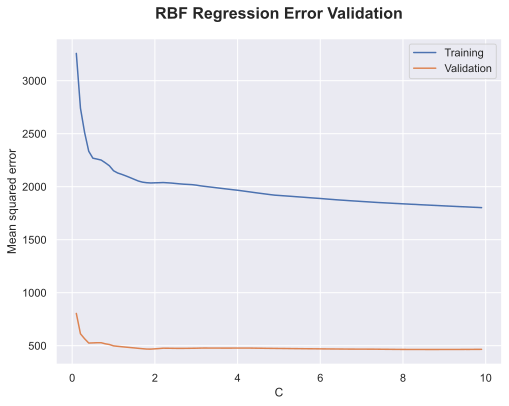

In [125]:
%%time
# Search the best degree and gamma
err_train_rbf = []
err_val_rbf = []
gammas = []
sc_X = StandardScaler()
sc_y = StandardScaler()
X_essen_train_sc = sc_X.fit_transform(X_essen_train)
y_essen_train_sc = sc_y.fit_transform(y_essen_train.values.reshape(-1, 1))
X_essen_val_sc = sc_X.fit_transform(X_essen_val)
y_essen_val_sc = sc_y.fit_transform(y_essen_val.values.reshape(-1, 1))
    
for C in np.arange(0.1, 10, 0.1):
    # Fit model
    err_val = []
    for gamma in np.arange(0.1, 10, 0.1):
        rbf_regressor_essen = SVR(kernel='rbf', gamma=gamma, C=C)
        rbf_model_essen = rbf_regressor_essen.fit(X_essen_train_sc, y_essen_train_sc)
        err_val.append(mean_squared_error(y_essen_val, sc_y.inverse_transform(rbf_model_essen.predict(X_essen_val_sc))))
    
    gammas.append(np.argmin(err_val)/10)
    rbf_reg_essen = SVR(kernel='rbf', C=C, gamma=np.argmin(err_val)/10+0.1)
    rbf_model_essen = rbf_reg_essen.fit(X_essen_train_sc, y_essen_train_sc)
    
    # Compute errors
    err_train_rbf.append(mean_squared_error(y_essen_train, sc_y.inverse_transform(rbf_model_essen.predict(X_essen_train_sc))))
    err_val_rbf.append(mean_squared_error(y_essen_val, sc_y.inverse_transform(rbf_model_essen.predict(X_essen_val_sc))))
    
plt.figure(figsize=(8, 6))
plt.plot(np.arange(0.1, 10, 0.1), err_train_rbf, np.arange(0.1, 10, 0.1), err_val_rbf)
plt.legend(["Training", "Validation"])
plt.xlabel("C")
plt.ylabel("Mean squared error")
plt.title("RBF Regression Error Validation", fontsize=16, fontweight="bold", pad=20)

In [126]:
print("Best validation value for C", np.argmin(err_val_rbf)/10+0.1, "and gamma", gammas[np.argmin(err_val_rbf)]+0.1)

Best validation value for C 8.7 and gamma 0.1


In [127]:
# Fit model (for the optimal C and gamma)
rbf_reg_essen = SVR(kernel='rbf', gamma=gammas[np.argmin(err_val_rbf)]+0.1, C=np.argmin(err_val_rbf)/10+0.1)
rbf_model_essen = rbf_reg_essen.fit(X_essen_train_sc, y_essen_train_sc)

# Predict
y_essen_pred_rbf = sc_y.inverse_transform(rbf_model_essen.predict(X_essen_val_sc))

In [128]:
r2_essen.append(r2_score(y_essen_val, y_essen_pred_rbf))
print("MSE:", mean_squared_error(y_essen_val, y_essen_pred_rbf))
print("MAE:", mean_absolute_error(y_essen_val, y_essen_pred_rbf))
print("R2: ", r2_score(y_essen_val, y_essen_pred_rbf))

MSE: 464.4133787145715
MAE: 16.00681573259685
R2:  0.7563000130935618


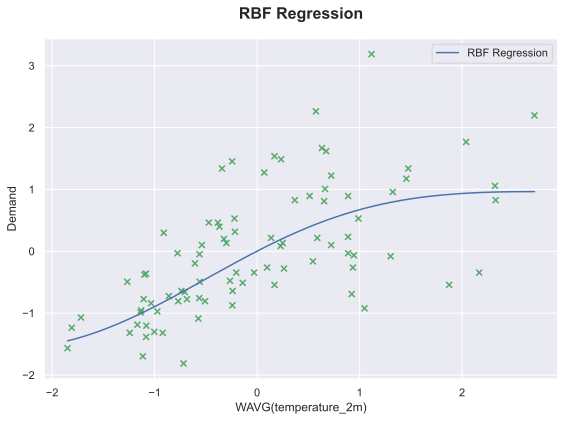

In [129]:
rbf_feature = "WAVG(temperature_2m)"
rbf_regressor_essen = SVR(kernel='rbf', gamma=gammas[np.argmin(err_val_rbf)]+0.1, C=np.argmin(err_val_rbf)/10+0.1)

X_essen_train_sc = sc_X.fit_transform(X_essen_train[rbf_feature].values.reshape(-1, 1))
y_essen_train_sc = sc_y.fit_transform(y_essen_train.values.reshape(-1, 1))

rbf_model_essen = rbf_regressor_essen.fit(X_essen_train_sc, y_essen_train_sc)
plot_scikit_output(X_essen_train_sc, 
                   y_essen_train_sc, 
                   rbf_model_essen, 
                   rbf_feature, 
                   "RBF Regression", 
                   "essen", 
                   "RBF Regression")

---

## K-Nearest-Neighbor (KNN) Regression

### Bonn

Which number of neighbors $k$ is optimal?

Text(0.5, 1.0, 'KNN Regression Error Validation')

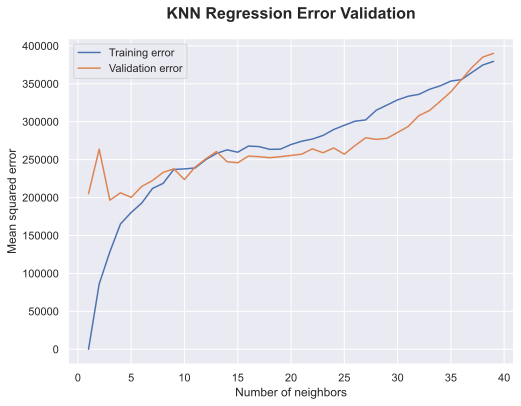

In [130]:
# Search the best number of neighbors
err_train_knn_bonn = [] 
err_val_knn_bonn = []

for k in range(1, 40):

    # Fit model
    KNN_reg = KNeighborsRegressor(n_neighbors=k)
    KNN_model = KNN_reg.fit(X_bonn_train, y_bonn_train)

    # Compute errors
    err_train_knn_bonn.append(mean_squared_error(y_bonn_train, KNN_model.predict(X_bonn_train)))
    err_val_knn_bonn.append(mean_squared_error(y_bonn_val, KNN_model.predict(X_bonn_val)))

plt.figure(figsize=(8, 6))
plt.plot(range(1, 40), err_train_knn_bonn, label="Training error")
plt.plot(range(1, 40), err_val_knn_bonn, label="Validation error")
plt.legend()
plt.xlabel("Number of neighbors")
plt.ylabel("Mean squared error")
plt.title("KNN Regression Error Validation", fontsize=16, fontweight="bold", pad=20)

In [131]:
print("Best validation value for", np.argmin(err_val_knn_bonn)+1, "neighbors")

Best validation value for 3 neighbors


Train model with optimal $k$.

In [132]:
# Fit model (for the optimal number of neighbors)
KNN_reg_bonn = KNeighborsRegressor(n_neighbors=np.argmin(err_val_knn_bonn)+1)
KNN_model_bonn = KNN_reg_bonn.fit(X_bonn_train, y_bonn_train)

# Predict
y_bonn_pred_knn = KNN_model_bonn.predict(X_bonn_val)

In [133]:
r2_bonn.append(r2_score(y_bonn_val, y_bonn_pred_knn))
print("MSE:", mean_squared_error(y_bonn_val, y_bonn_pred_knn))
print("MAE:", mean_absolute_error(y_bonn_val, y_bonn_pred_knn))
print("R2: ", r2_score(y_bonn_val, y_bonn_pred_knn))

MSE: 196548.7296296297
MAE: 329.23333333333335
R2:  0.7358682888691673


Plot for a single feature:

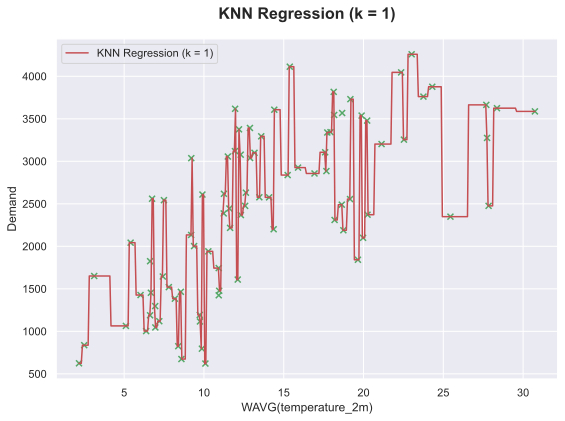

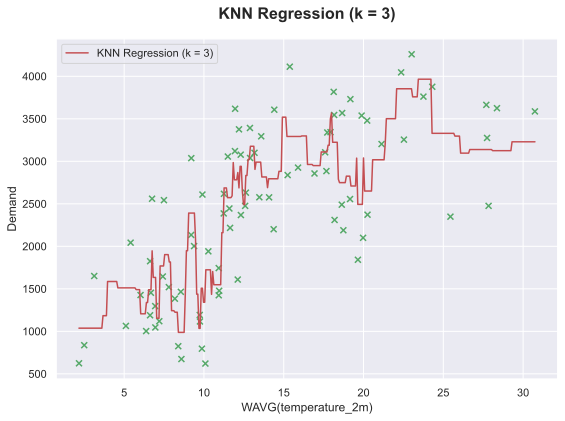

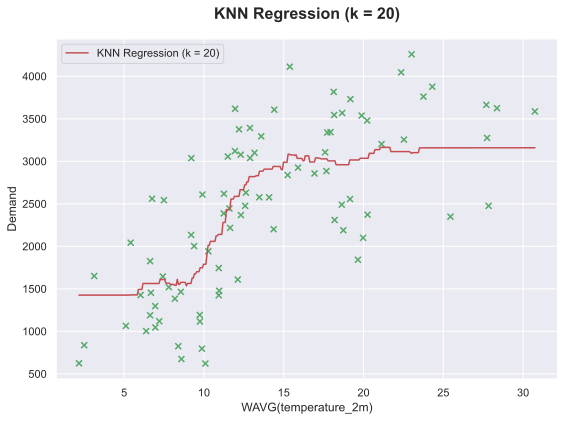

In [134]:
knn_feature = "WAVG(temperature_2m)"
for k in (1, np.argmin(err_val_knn_bonn)+1, 20):
    KNN_reg_bonn = KNeighborsRegressor(n_neighbors=k)
    KNN_model_bonn = KNN_reg_bonn.fit(X_bonn_train[knn_feature].values.reshape(-1, 1), y_bonn_train)
    plot_scikit_output(X_bonn_train[knn_feature], 
                       y_bonn_train, 
                       KNN_model_bonn, 
                       knn_feature, 
                       f"KNN Regression (k = {k})",
                       "Bonn",
                       f"KNN Regression (k = {k})")

### Essen

Which number of neighbors $k$ is optimal?

Text(0.5, 1.0, 'KNN Regression Error Validation')

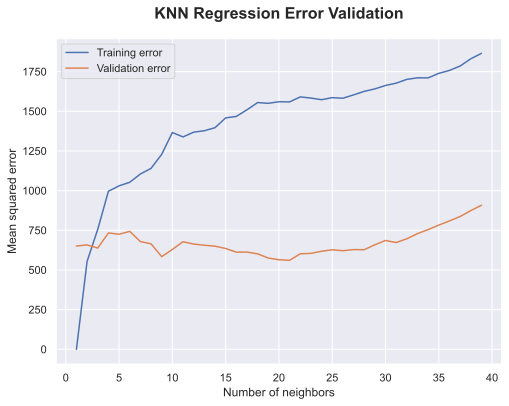

In [135]:
# Search the best number of neighbors
err_train_knn_essen = [] 
err_val_knn_essen = []

for k in range(1, 40):

    # Fit model
    KNN_reg = KNeighborsRegressor(n_neighbors=k)
    KNN_model = KNN_reg.fit(X_essen_train, y_essen_train)

    # Compute errors
    err_train_knn_essen.append(mean_squared_error(y_essen_train, KNN_model.predict(X_essen_train)))
    err_val_knn_essen.append(mean_squared_error(y_essen_val, KNN_model.predict(X_essen_val)))

plt.figure(figsize=(8, 6))
plt.plot(range(1, 40), err_train_knn_essen, label="Training error")
plt.plot(range(1, 40), err_val_knn_essen, label="Validation error")
plt.legend()
plt.xlabel("Number of neighbors")
plt.ylabel("Mean squared error")
plt.title("KNN Regression Error Validation", fontsize=16, fontweight="bold", pad=20)

In [136]:
print("Best validation value for", np.argmin(err_val_knn_essen)+1, "neighbors")

Best validation value for 21 neighbors


Train model with optimal $k$.

In [137]:
# Fit model (for the optimal number of neighbors)
KNN_reg_essen = KNeighborsRegressor(n_neighbors=np.argmin(err_val_knn_essen)+1)
KNN_model_essen = KNN_reg_essen.fit(X_essen_train, y_essen_train)

# Predict
y_essen_pred_knn = KNN_model_essen.predict(X_essen_val)

In [138]:
r2_essen.append(r2_score(y_essen_val, y_essen_pred_knn))
print("MSE:", mean_squared_error(y_essen_val, y_essen_pred_knn))
print("MAE:", mean_absolute_error(y_essen_val, y_essen_pred_knn))
print("R2: ", r2_score(y_essen_val, y_essen_pred_knn))

MSE: 560.6102796674227
MAE: 19.142857142857146
R2:  0.7058208826956884


Plot for a single feature:

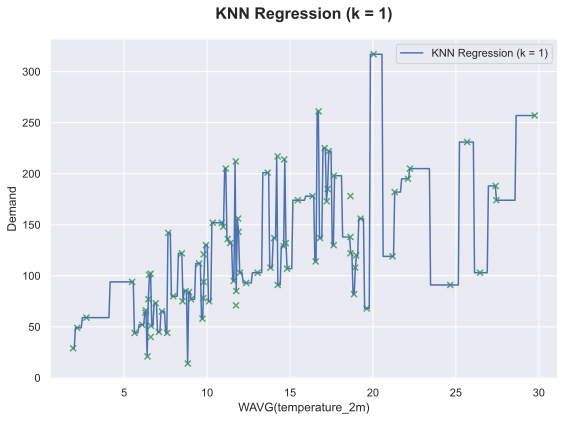

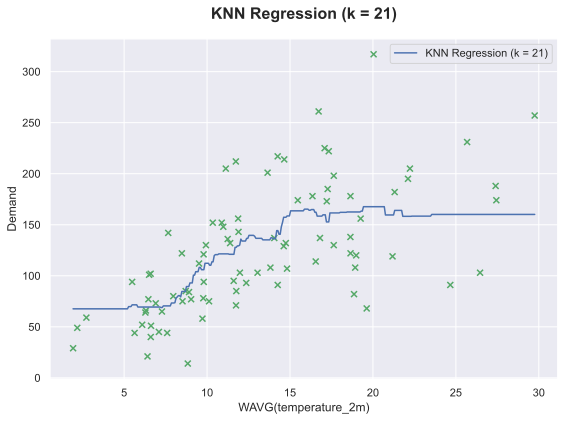

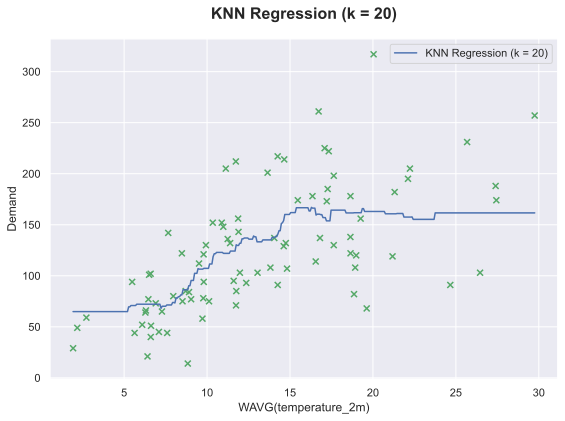

In [139]:
knn_feature = "WAVG(temperature_2m)"
for k in (1, np.argmin(err_val_knn_essen)+1, 20):
    KNN_reg_essen = KNeighborsRegressor(n_neighbors=k)
    KNN_model_essen = KNN_reg_essen.fit(X_essen_train[knn_feature].values.reshape(-1, 1), y_essen_train)
    plot_scikit_output(X_essen_train[knn_feature], 
                       y_essen_train, 
                       KNN_model_essen, 
                       knn_feature, 
                       f"KNN Regression (k = {k})",
                       "Essen",
                       f"KNN Regression (k = {k})")

---

## Neural Network

### Bonn

In [140]:
# Normalizing training data
st_scaler = StandardScaler()
st_scaler.fit(X_bonn_train)
X_bonn_train_scaled = st_scaler.transform(X_bonn_train)
st_scaler.fit(X_bonn_val)
X_bonn_val_scaled = st_scaler.transform(X_bonn_val)

network_bonn = Sequential()
network_bonn.add(Dense(input_shape=[X_bonn_train.shape[1]], units=360, activation="relu"))
network_bonn.add(Dropout(rate=0.1))
network_bonn.add(Dense(units=360, activation="relu"))
network_bonn.add(Dropout(rate=0.1))
network_bonn.add(Dense(1))

# Compiling the ANN
network_bonn.compile(loss='mse', 
                     optimizer="adam",
                     metrics=["mae", "mse"])

network_bonn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 360)               3600      
_________________________________________________________________
dropout (Dropout)            (None, 360)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 360)               129960    
_________________________________________________________________
dropout_1 (Dropout)          (None, 360)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 361       
Total params: 133,921
Trainable params: 133,921
Non-trainable params: 0
_________________________________________________________________


In [141]:
%%time
history_bonn = network_bonn.fit(X_bonn_train_scaled, y_bonn_train.values, 
                                validation_data = (X_bonn_val_scaled, y_bonn_val.values),
                                epochs=200)

Epoch 1/200
3/3 [==============================] - 2s 679ms/step - loss: 6917024.6250 - mae: 2452.9792 - mse: 6917024.6250 - val_loss: 4257011.5000 - val_mae: 1874.3185 - val_mse: 4257011.5000
Epoch 2/200
3/3 [==============================] - 0s 52ms/step - loss: 6919449.7500 - mae: 2436.1703 - mse: 6919449.7500 - val_loss: 4252302.5000 - val_mae: 1873.0935 - val_mse: 4252302.5000
Epoch 3/200
3/3 [==============================] - 0s 56ms/step - loss: 6909781.7500 - mae: 2450.3765 - mse: 6909781.7500 - val_loss: 4246883.0000 - val_mae: 1871.6967 - val_mse: 4246883.0000
Epoch 4/200
3/3 [==============================] - 0s 55ms/step - loss: 7158636.2500 - mae: 2493.8610 - mse: 7158636.2500 - val_loss: 4240392.5000 - val_mae: 1870.0396 - val_mse: 4240392.5000
Epoch 5/200
3/3 [==============================] - 0s 55ms/step - loss: 6710918.8750 - mae: 2422.4422 - mse: 6710918.8750 - val_loss: 4232656.0000 - val_mae: 1868.0728 - val_mse: 4232656.0000
Epoch 6/200
3/3 [======================

Epoch 87/200
3/3 [==============================] - 0s 32ms/step - loss: 237692.5117 - mae: 392.2125 - mse: 237692.5117 - val_loss: 407449.1250 - val_mae: 519.6313 - val_mse: 407449.1250
Epoch 88/200
3/3 [==============================] - 0s 31ms/step - loss: 249930.3477 - mae: 409.5332 - mse: 249930.3477 - val_loss: 408674.1562 - val_mae: 520.1921 - val_mse: 408674.1562
Epoch 89/200
3/3 [==============================] - 0s 32ms/step - loss: 253111.3945 - mae: 406.8334 - mse: 253111.3945 - val_loss: 410529.6562 - val_mae: 521.0765 - val_mse: 410529.6562
Epoch 90/200
3/3 [==============================] - 0s 31ms/step - loss: 257725.4922 - mae: 417.5416 - mse: 257725.4922 - val_loss: 410854.2812 - val_mae: 521.1568 - val_mse: 410854.2812
Epoch 91/200
3/3 [==============================] - 0s 31ms/step - loss: 234503.2969 - mae: 385.0751 - mse: 234503.2969 - val_loss: 411405.4375 - val_mae: 521.4361 - val_mse: 411405.4375
Epoch 92/200
3/3 [==============================] - 0s 33ms/step 

Epoch 131/200
3/3 [==============================] - 0s 33ms/step - loss: 185103.4258 - mae: 345.4837 - mse: 185103.4258 - val_loss: 428908.3750 - val_mae: 532.6103 - val_mse: 428908.3750
Epoch 132/200
3/3 [==============================] - 0s 33ms/step - loss: 192929.0781 - mae: 350.8108 - mse: 192929.0781 - val_loss: 428389.3438 - val_mae: 532.3594 - val_mse: 428389.3438
Epoch 133/200
3/3 [==============================] - 0s 33ms/step - loss: 180990.9648 - mae: 351.0979 - mse: 180990.9570 - val_loss: 427195.6875 - val_mae: 531.6360 - val_mse: 427195.6875
Epoch 134/200
3/3 [==============================] - 0s 30ms/step - loss: 196677.6914 - mae: 359.9165 - mse: 196677.6914 - val_loss: 427883.7188 - val_mae: 532.0988 - val_mse: 427883.7188
Epoch 135/200
3/3 [==============================] - 0s 32ms/step - loss: 193174.0078 - mae: 357.7999 - mse: 193174.0078 - val_loss: 428129.4062 - val_mae: 532.4235 - val_mse: 428129.4062
Epoch 136/200
3/3 [==============================] - 0s 30ms

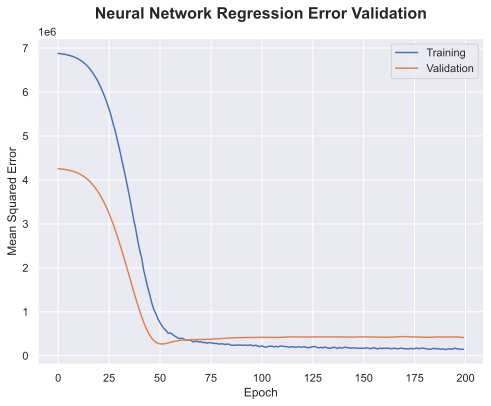

In [142]:
plt.figure(figsize=(8, 6))

plt.plot(history_bonn.history['mse'])
plt.plot(history_bonn.history['val_mse'])
plt.legend(['Training', 'Validation'])
plt.xlabel("Epoch")
plt.ylabel("Mean Squared Error")
plt.title("Neural Network Regression Error Validation", fontsize=16, fontweight="bold", pad=20)

plt.show()

In [143]:
# Predict on validation set
y_bonn_pred_network = network_bonn.predict(X_bonn_val_scaled)

In [144]:
r2_bonn.append(r2_score(y_bonn_val, y_bonn_pred_network))
print("MSE:", mean_squared_error(y_bonn_val, y_bonn_pred_network))
print("MAE:", mean_absolute_error(y_bonn_val, y_bonn_pred_network))
print("R2: ", r2_score(y_bonn_val, y_bonn_pred_network))

MSE: 413062.2003392597
MAE: 523.613427734375
R2:  0.4449069908278448


### Essen

In [145]:
# Normalizing training data
st_scaler = StandardScaler()
st_scaler.fit(X_essen_train)
X_essen_train_scaled = st_scaler.transform(X_essen_train)
st_scaler.fit(X_essen_val)
X_essen_val_scaled = st_scaler.transform(X_essen_val)

network_essen = Sequential()
network_essen.add(Dense(input_shape=[X_essen_train.shape[1]], units=36, activation="relu"))
network_essen.add(Dropout(rate=0.1))
network_essen.add(Dense(units=36, activation="relu"))
network_essen.add(Dropout(rate=0.1))
network_essen.add(Dense(1))

# Compiling the ANN
network_essen.compile(loss='mse', 
                     optimizer="adam",
                     metrics=["mae", "mse"])

network_essen.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 36)                360       
_________________________________________________________________
dropout_2 (Dropout)          (None, 36)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 36)                1332      
_________________________________________________________________
dropout_3 (Dropout)          (None, 36)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 37        
Total params: 1,729
Trainable params: 1,729
Non-trainable params: 0
_________________________________________________________________


In [146]:
%%time
history_essen = network_essen.fit(X_essen_train_scaled, y_essen_train.values, 
                                validation_data = (X_essen_val_scaled, y_essen_val.values),
                                epochs=200)

Epoch 1/200
3/3 [==============================] - 1s 137ms/step - loss: 19412.8223 - mae: 124.9450 - mse: 19412.8223 - val_loss: 10266.0664 - val_mae: 91.3558 - val_mse: 10266.0664
Epoch 2/200
3/3 [==============================] - 0s 38ms/step - loss: 19548.1367 - mae: 125.6452 - mse: 19548.1367 - val_loss: 10238.4023 - val_mae: 91.2138 - val_mse: 10238.4023
Epoch 3/200
3/3 [==============================] - 0s 35ms/step - loss: 21062.0605 - mae: 130.8513 - mse: 21062.0605 - val_loss: 10212.4756 - val_mae: 91.0808 - val_mse: 10212.4756
Epoch 4/200
3/3 [==============================] - 0s 30ms/step - loss: 18096.9888 - mae: 120.5281 - mse: 18096.9888 - val_loss: 10188.1816 - val_mae: 90.9552 - val_mse: 10188.1816
Epoch 5/200
3/3 [==============================] - 0s 31ms/step - loss: 17878.0552 - mae: 120.6551 - mse: 17878.0552 - val_loss: 10164.6143 - val_mae: 90.8324 - val_mse: 10164.6143
Epoch 6/200
3/3 [==============================] - 0s 35ms/step - loss: 20181.5703 - mae: 127.

3/3 [==============================] - 0s 33ms/step - loss: 2710.0240 - mae: 40.9210 - mse: 2710.0240 - val_loss: 789.3466 - val_mae: 23.6456 - val_mse: 789.3466
Epoch 93/200
3/3 [==============================] - 0s 33ms/step - loss: 2704.7485 - mae: 40.0422 - mse: 2704.7485 - val_loss: 798.1057 - val_mae: 23.6621 - val_mse: 798.1057
Epoch 94/200
3/3 [==============================] - 0s 35ms/step - loss: 2598.1293 - mae: 38.8752 - mse: 2598.1293 - val_loss: 812.8552 - val_mae: 23.7179 - val_mse: 812.8552
Epoch 95/200
3/3 [==============================] - 0s 34ms/step - loss: 1773.4966 - mae: 33.2018 - mse: 1773.4966 - val_loss: 832.2076 - val_mae: 23.8757 - val_mse: 832.2076
Epoch 96/200
3/3 [==============================] - 0s 35ms/step - loss: 1951.3706 - mae: 33.9281 - mse: 1951.3706 - val_loss: 856.5330 - val_mae: 24.1507 - val_mse: 856.5330
Epoch 97/200
3/3 [==============================] - 0s 32ms/step - loss: 2163.0075 - mae: 35.6218 - mse: 2163.0075 - val_loss: 884.1943 - 

3/3 [==============================] - 0s 37ms/step - loss: 1094.3713 - mae: 23.5116 - mse: 1094.3712 - val_loss: 1356.2239 - val_mae: 29.7198 - val_mse: 1356.2239
Epoch 185/200
3/3 [==============================] - 0s 36ms/step - loss: 1017.2560 - mae: 24.1543 - mse: 1017.2560 - val_loss: 1361.0701 - val_mae: 29.7830 - val_mse: 1361.0701
Epoch 186/200
3/3 [==============================] - 0s 33ms/step - loss: 1230.6198 - mae: 27.0999 - mse: 1230.6198 - val_loss: 1368.7722 - val_mae: 29.8769 - val_mse: 1368.7722
Epoch 187/200
3/3 [==============================] - 0s 34ms/step - loss: 949.7539 - mae: 22.9109 - mse: 949.7539 - val_loss: 1374.3737 - val_mae: 29.9477 - val_mse: 1374.3737
Epoch 188/200
3/3 [==============================] - 0s 34ms/step - loss: 1391.1680 - mae: 27.3304 - mse: 1391.1680 - val_loss: 1378.0106 - val_mae: 29.9986 - val_mse: 1378.0106
Epoch 189/200
3/3 [==============================] - 0s 33ms/step - loss: 926.1793 - mae: 23.9947 - mse: 926.1793 - val_loss: 

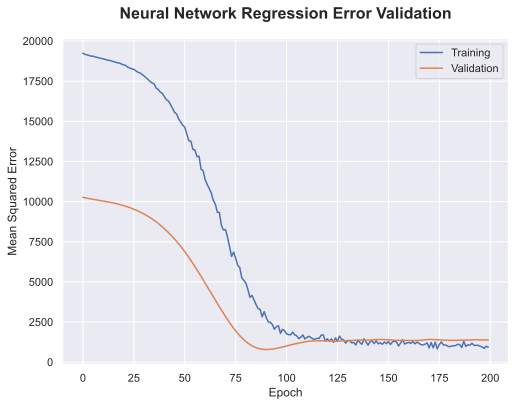

In [147]:
plt.figure(figsize=(8, 6))

plt.plot(history_essen.history['mse'])
plt.plot(history_essen.history['val_mse'])
plt.legend(['Training', 'Validation'])
plt.xlabel("Epoch")
plt.ylabel("Mean Squared Error")
plt.title("Neural Network Regression Error Validation", fontsize=16, fontweight="bold", pad=20)

plt.show()

In [148]:
# Predict on validation set
y_essen_pred_network = network_essen.predict(X_essen_val_scaled)

In [149]:
r2_essen.append(r2_score(y_essen_val, y_essen_pred_network))
print("MSE:", mean_squared_error(y_essen_val, y_essen_pred_network))
print("MAE:", mean_absolute_error(y_essen_val, y_essen_pred_network))
print("R2: ", r2_score(y_essen_val, y_essen_pred_network))

MSE: 1388.6317177984413
MAE: 30.188440068562826
R2:  0.2713182975434232


---

# $\mathrm{R^2}$ Scores

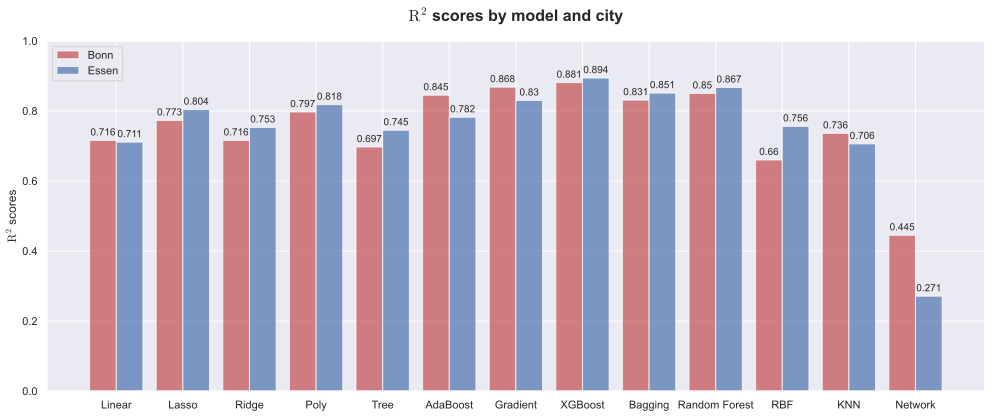

In [150]:
labels = ['Linear', 'Lasso', 'Ridge', 'Poly', 'Tree', 'AdaBoost', 'Gradient', 'XGBoost', 'Bagging', 'Random Forest', 'RBF', 'KNN', 'Network']
r2_bonn_rounded = [ round(elem, 3) for elem in r2_bonn ]
r2_essen_rounded = [ round(elem, 3) for elem in r2_essen ]

x = np.arange(len(labels))  # the label locations
width = 0.4  # the width of the bars

fig, ax = plt.subplots(figsize=(14,6))
rects1 = ax.bar(x - width/2, r2_bonn_rounded, width, label='Bonn', color='C3', alpha=0.7)
rects2 = ax.bar(x + width/2, r2_essen_rounded, width, label='Essen', color='C0', alpha=0.7)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('$\mathrm{R^2}$ scores')
ax.set_ylim([0, 1])
ax.set_title('$\mathrm{R^2}$ scores by model and city', fontsize=16, fontweight="bold", pad=20)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc=2)


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=10)


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

---

# Testing the Selected Models

For our final report we pick three regression models (XGBoost, Polynomial and Random Forest) based on their validation scores and also from the angle of working with a small data set.
In the following we test these models with the test split and calculate their test metrics as illustrated in the report. 
Furthermore we use the linear regression model as a comparison for the other models. 
With this we can asses whether a model is better or worse than a really “simple andintuitive“ model like the linear regression.

## XGBoost

### Bonn

In [151]:
# Fit
xg_model_bonn = xgb.XGBRegressor(max_depth = np.argmin(err_val_xg_bonn)+1, random_state=42)
xg_model_bonn.fit(X_bonn_train, y_bonn_train)

# Predict
y_bonn_pred_xg_train = xg_model_bonn.predict(X_bonn_train)
y_bonn_pred_xg_val = xg_model_bonn.predict(X_bonn_val)
y_bonn_pred_xg_test = xg_model_bonn.predict(X_bonn_test)

In [152]:
print("Training performance:")
print("MSE:", mean_squared_error(y_bonn_train, y_bonn_pred_xg_train))
print("MAE:", mean_absolute_error(y_bonn_train, y_bonn_pred_xg_train))
print("R2: ", r2_score(y_bonn_train, y_bonn_pred_xg_train))
print()

print("Validation performance:")
print("MSE:", mean_squared_error(y_bonn_val, y_bonn_pred_xg_val))
print("MAE:", mean_absolute_error(y_bonn_val, y_bonn_pred_xg_val))
print("R2: ", r2_score(y_bonn_val, y_bonn_pred_xg_val))
print()

print("Test performance:")
print("MSE:", mean_squared_error(y_bonn_test, y_bonn_pred_xg_test))
print("MAE:", mean_absolute_error(y_bonn_test, y_bonn_pred_xg_test))
print("R2: ", r2_score(y_bonn_test, y_bonn_pred_xg_test))

Training performance:
MSE: 3427.190863160695
MAE: 44.24484989560884
R2:  0.9962800895240088

Validation performance:
MSE: 88506.60793370195
MAE: 222.2678202311198
R2:  0.8810605296510129

Test performance:
MSE: 61210.30327062532
MAE: 203.56653645833333
R2:  0.9225875229883764


### Essen

In [153]:
# Fit
xg_model_essen = xgb.XGBRegressor(max_depth = np.argmin(err_val_xg_essen)+1, random_state=42)
xg_model_essen.fit(X_essen_train, y_essen_train)

# Predict
y_essen_pred_xg_train = xg_model_essen.predict(X_essen_train)
y_essen_pred_xg_val = xg_model_essen.predict(X_essen_val)
y_essen_pred_xg_test = xg_model_essen.predict(X_essen_test)

In [154]:
print("Training performance:")
print("MSE:", mean_squared_error(y_essen_train, y_essen_pred_xg_train))
print("MAE:", mean_absolute_error(y_essen_train, y_essen_pred_xg_train))
print("R2: ", r2_score(y_essen_train, y_essen_pred_xg_train))
print()

print("Validation performance:")
print("MSE:", mean_squared_error(y_essen_val, y_essen_pred_xg_val))
print("MAE:", mean_absolute_error(y_essen_val, y_essen_pred_xg_val))
print("R2: ", r2_score(y_essen_val, y_essen_pred_xg_val))
print()

print("Test performance:")
print("MSE:", mean_squared_error(y_essen_test, y_essen_pred_xg_test))
print("MAE:", mean_absolute_error(y_essen_test, y_essen_pred_xg_test))
print("R2: ", r2_score(y_essen_test, y_essen_pred_xg_test))

Training performance:
MSE: 2.3727884926584323e-05
MAE: 0.0035382194080572017
R2:  0.9999999935419651

Validation performance:
MSE: 201.58020278488027
MAE: 11.733221117655436
R2:  0.8942211938096108

Test performance:
MSE: 786.4095543444745
MAE: 20.641736666361492
R2:  0.8233420928451055


## Polynomial Regression

### Bonn

In [155]:
# Fit model (for the optimal degree and alpha)
poly = PolynomialFeatures(degree=np.argmin(err_val_poly_bonn)+1)
X_poly_train = poly.fit_transform(X_bonn_train)
X_poly_val = poly.transform(X_bonn_val)
X_poly_test = poly.transform(X_bonn_test)
poly_reg_bonn = Lasso(alpha=alphas_poly_bonn[np.argmin(err_val_poly_bonn)])
poly_model_bonn = poly_reg_bonn.fit(X_poly_train, y_bonn_train)

# Predict
y_bonn_pred_poly_train = poly_model_bonn.predict(X_poly_train)
y_bonn_pred_poly_val = poly_model_bonn.predict(X_poly_val)
y_bonn_pred_poly_test = poly_model_bonn.predict(X_poly_test)

In [156]:
print("Training performance:")
print("MSE:", mean_squared_error(y_bonn_train, y_bonn_pred_poly_train))
print("MAE:", mean_absolute_error(y_bonn_train, y_bonn_pred_poly_train))
print("R2: ", r2_score(y_bonn_train, y_bonn_pred_poly_train))
print()

print("Validation performance:")
print("MSE:", mean_squared_error(y_bonn_val, y_bonn_pred_poly_val))
print("MAE:", mean_absolute_error(y_bonn_val, y_bonn_pred_poly_val))
print("R2: ", r2_score(y_bonn_val, y_bonn_pred_poly_val))
print()

print("Test performance:")
print("MSE:", mean_squared_error(y_bonn_test, y_bonn_pred_poly_test))
print("MAE:", mean_absolute_error(y_bonn_test, y_bonn_pred_poly_test))
print("R2: ", r2_score(y_bonn_test, y_bonn_pred_poly_test))

Training performance:
MSE: 48526.72922990272
MAE: 173.59591195543268
R2:  0.9473285569332366

Validation performance:
MSE: 150980.27343888103
MAE: 298.3122299657898
R2:  0.7971053893578514

Test performance:
MSE: 103868.41180288336
MAE: 241.1905698803677
R2:  0.8686379480040368


### Essen

In [157]:
# Fit model (for the optimal degree and alpha)
poly = PolynomialFeatures(degree=np.argmin(err_val_poly_essen)+1)
X_poly_train = poly.fit_transform(X_essen_train)
X_poly_val = poly.transform(X_essen_val)
X_poly_test = poly.transform(X_essen_test)
poly_reg_essen = Lasso(alpha=alphas_poly_essen[np.argmin(err_val_poly_essen)])
poly_model_essen = poly_reg_essen.fit(X_poly_train, y_essen_train)

# Predict
y_essen_pred_poly_train = poly_model_essen.predict(X_poly_train)
y_essen_pred_poly_val = poly_model_essen.predict(X_poly_val)
y_essen_pred_poly_test = poly_model_essen.predict(X_poly_test)

In [158]:
print("Training performance:")
print("MSE:", mean_squared_error(y_essen_train, y_essen_pred_poly_train))
print("MAE:", mean_absolute_error(y_essen_train, y_essen_pred_poly_train))
print("R2: ", r2_score(y_essen_train, y_essen_pred_poly_train))
print()

print("Validation performance:")
print("MSE:", mean_squared_error(y_essen_val, y_essen_pred_poly_val))
print("MAE:", mean_absolute_error(y_essen_val, y_essen_pred_poly_val))
print("R2: ", r2_score(y_essen_val, y_essen_pred_poly_val))
print()

print("Test performance:")
print("MSE:", mean_squared_error(y_essen_test, y_essen_pred_poly_test))
print("MAE:", mean_absolute_error(y_essen_test, y_essen_pred_poly_test))
print("R2: ", r2_score(y_essen_test, y_essen_pred_poly_test))

Training performance:
MSE: 423.63935219134345
MAE: 15.185352446424291
R2:  0.8846977842113857

Validation performance:
MSE: 346.02371032515833
MAE: 14.398124882285979
R2:  0.8184247535913796

Test performance:
MSE: 449.31204342410354
MAE: 15.424837129082485
R2:  0.8990671911190662


## Random Forest

### Bonn

In [159]:
# Fit the model
rf_regressor_bonn = RandomForestRegressor(n_estimators=1000, 
                                           bootstrap=True, # we select boostrapp, i.e. we use bagging
                                           random_state=42,
                                           max_depth=np.argmin(err_val_rf_bonn)+1,
                                           criterion="mse") 
rf_model_bonn = rf_regressor_bonn.fit(X_bonn_train, y_bonn_train)

# Predict
y_bonn_predict_rf_train = rf_model_bonn.predict(X_bonn_train)
y_bonn_predict_rf_val = rf_model_bonn.predict(X_bonn_val)
y_bonn_predict_rf_test = rf_model_bonn.predict(X_bonn_test)

In [160]:
print("Training performance:")
print("MSE:", mean_squared_error(y_bonn_train, y_bonn_predict_rf_train))
print("MAE:", mean_absolute_error(y_bonn_train, y_bonn_predict_rf_train))
print("R2: ", r2_score(y_bonn_train, y_bonn_predict_rf_train))
print()

print("Validation performance:")
print("MSE:", mean_squared_error(y_bonn_val, y_bonn_predict_rf_val))
print("MAE:", mean_absolute_error(y_bonn_val, y_bonn_predict_rf_val))
print("R2: ", r2_score(y_bonn_val, y_bonn_predict_rf_val))
print()

print("Test performance:")
print("MSE:", mean_squared_error(y_bonn_test, y_bonn_predict_rf_test))
print("MAE:", mean_absolute_error(y_bonn_test, y_bonn_predict_rf_test))
print("R2: ", r2_score(y_bonn_test, y_bonn_predict_rf_test))

Training performance:
MSE: 49958.2234791281
MAE: 172.78232485639646
R2:  0.9457747974063734

Validation performance:
MSE: 111398.94115418046
MAE: 259.92860881122726
R2:  0.8502967024988547

Test performance:
MSE: 73465.66582055057
MAE: 207.94846202180597
R2:  0.9070882047204912


### Essen

In [161]:
# Fit the model
rf_regressor_essen = RandomForestRegressor(n_estimators=1000, 
                                           bootstrap=True, # we select boostrapp, i.e. we use bagging
                                           random_state=42,
                                           max_depth=np.argmin(err_val_rf_essen)+1,
                                           criterion="mse") 
rf_model_essen = rf_regressor_essen.fit(X_essen_train, y_essen_train)

# Predict
y_essen_predict_rf_train = rf_model_essen.predict(X_essen_train)
y_essen_predict_rf_val = rf_model_essen.predict(X_essen_val)
y_essen_predict_rf_test = rf_model_essen.predict(X_essen_test)

In [162]:
print("Training performance:")
print("MSE:", mean_squared_error(y_essen_train, y_essen_predict_rf_train))
print("MAE:", mean_absolute_error(y_essen_train, y_essen_predict_rf_train))
print("R2: ", r2_score(y_essen_train, y_essen_predict_rf_train))
print()

print("Validation performance:")
print("MSE:", mean_squared_error(y_essen_val, y_essen_predict_rf_val))
print("MAE:", mean_absolute_error(y_essen_val, y_essen_predict_rf_val))
print("R2: ", r2_score(y_essen_val, y_essen_predict_rf_val))
print()

print("Test performance:")
print("MSE:", mean_squared_error(y_essen_test, y_essen_predict_rf_test))
print("MAE:", mean_absolute_error(y_essen_test, y_essen_predict_rf_test))
print("R2: ", r2_score(y_essen_test, y_essen_predict_rf_test))

Training performance:
MSE: 221.0944919007398
MAE: 10.781473321511886
R2:  0.9398245590666965

Validation performance:
MSE: 253.02334811516124
MAE: 12.139217795723965
R2:  0.867226506709693

Test performance:
MSE: 735.248660928562
MAE: 18.623884915876804
R2:  0.8348348020945036


## Linear Regression (Benchmark)

### Bonn

In [163]:
# Fit model
lr_bonn = LinearRegression(normalize=True)
lr_bonn.fit(X_bonn_train, y_bonn_train)

# Predict
y_bonn_pred_lr_train = lr_bonn.predict(X_bonn_train)
y_bonn_pred_lr_val = lr_bonn.predict(X_bonn_val)
y_bonn_pred_lr_test = lr_bonn.predict(X_bonn_test)

In [164]:
print("Training performance:")
print("MSE:", mean_squared_error(y_bonn_train, y_bonn_pred_lr_train))
print("MAE:", mean_absolute_error(y_bonn_train, y_bonn_pred_lr_train))
print("R2: ", r2_score(y_bonn_train, y_bonn_pred_lr_train))
print()

print("Validation performance:")
print("MSE:", mean_squared_error(y_bonn_val, y_bonn_pred_lr_val))
print("MAE:", mean_absolute_error(y_bonn_val, y_bonn_pred_lr_val))
print("R2: ", r2_score(y_bonn_val, y_bonn_pred_lr_val))
print()

print("Test performance:")
print("MSE:", mean_squared_error(y_bonn_test, y_bonn_pred_lr_test))
print("MAE:", mean_absolute_error(y_bonn_test, y_bonn_pred_lr_test))
print("R2: ", r2_score(y_bonn_test, y_bonn_pred_lr_test))

Training performance:
MSE: 135098.49140214446
MAE: 293.96037883398293
R2:  0.8533626186800816

Validation performance:
MSE: 211483.71545734495
MAE: 362.6890928917489
R2:  0.7157979308982834

Test performance:
MSE: 81123.66874623872
MAE: 236.00212321650238
R2:  0.8974031526334469


### Essen

In [165]:
# Fit model
lr_essen = LinearRegression(normalize=True)
lr_essen.fit(X_essen_train, y_essen_train)

# Predict
y_essen_pred_lr_train = lr_essen.predict(X_essen_train)
y_essen_pred_lr_val = lr_essen.predict(X_essen_val)
y_essen_pred_lr_test = lr_essen.predict(X_essen_test)

In [166]:
print("Training performance:")
print("MSE:", mean_squared_error(y_essen_train, y_essen_pred_lr_train))
print("MAE:", mean_absolute_error(y_essen_train, y_essen_pred_lr_train))
print("R2: ", r2_score(y_essen_train, y_essen_pred_lr_train))
print()

print("Validation performance:")
print("MSE:", mean_squared_error(y_essen_val, y_essen_pred_lr_val))
print("MAE:", mean_absolute_error(y_essen_val, y_essen_pred_lr_val))
print("R2: ", r2_score(y_essen_val, y_essen_pred_lr_val))
print()

print("Test performance:")
print("MSE:", mean_squared_error(y_essen_test, y_essen_pred_lr_test))
print("MAE:", mean_absolute_error(y_essen_test, y_essen_pred_lr_test))
print("R2: ", r2_score(y_essen_test, y_essen_pred_lr_test))

Training performance:
MSE: 677.8974341036227
MAE: 19.18339633186682
R2:  0.8154961860241439

Validation performance:
MSE: 550.3856865695692
MAE: 18.111860237749212
R2:  0.7111862173700843

Test performance:
MSE: 731.5998219505037
MAE: 19.495356598364946
R2:  0.8356544720156635


---

# Experiment: Which subset of features produces the optimal model?  
We asked ourselves the question what would be the best feature selection we could have chosen. To find out we iterated over all possible feature subsets and validated them on a simple linear regression model. For the sake of simplicity we performed this experiment only for the dataset of Bonn.

In [ ]:
# Features we picked for examination
# If we pick all_features, there are 22 features => 2**22=4.194.304 possible subsets 
# Careful: Picking all features leads to a long algorithm runtime!!
relevant_features = [ 
    'isHoliday',
    'isWeekend', 
    'isSemester', 
    'isSchool',
    'isKarneval', 
    'WAVG(temperature_2m)', 
    'WAVG(dew_point_temperature_2m)',
    'WAVG(relative_humidity)', 
    'WAVG(precipitation)',
    'WAVG(has_precipitated)', 
    'WAVG(wind_velocity_10m)',
    'WAVG(wind_direction_10m)', 
    'WAVG(mean_wind_speed_10m)',
    'WAVG(mean_wind_direction_10m)',
    'WAVG(air_pressure_station_level)',
    'WAVG(air_pressure_sea_level)', 
    'WAVG(cloud_coverage)',
    'WAVG(soil_temperature_5cm)', 
    'WAVG(soil_temperature_10cm)',
    'WAVG(soil_temperature_20cm)', 
    'WAVG(soil_temperature_50cm)',
    'WAVG(soil_temperature_100cm)'
]

def powerset(s):
    p = (combinations(s, r) for r in range(1,len(s)+1)) 
    p = chain.from_iterable(p)
    p = list(p)
    return p

In [ ]:
%%time
# Create training, validation and test data:
X, y = df_bonn.drop("demand", axis=1), df_bonn["demand"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

score_val_feature_sets = dict()

for feature_set in tqdm(powerset(relevant_features)):   
    feature_set = list(feature_set)
    # Evaluate this feature set by fitting linear regression and calculating the score using validation data
    # => Optimal with respect to simple linear regression model.
    # We could also optimize a regularized linear regression model or even linear regression model on non-linear data.
    lr = LinearRegression(normalize=True).fit(X_train[feature_set], y_train)
    score = lr.score(X_val[feature_set], y_val)
    score_val_feature_sets[", ".join(feature_set)] = score

scores = pd.DataFrame(score_val_feature_sets.values(), index=score_val_feature_sets.keys())
scores = scores.sort_values(0, ascending=False)
scores["len"] = scores.index.map(lambda s: len(s.split(","))) # how big is the subset (relevant_features has length 22)
scores = scores.reset_index()
scores = scores.rename(columns={0: "score", "index": "feature_set"})
scores

In [ ]:
optimal_features = scores.loc[0, "feature_set"].split(", ")
optimal_features

Which features are in each feature set of the top 100?

In [ ]:
for i in range(101):
    optimal_features.append(scores.loc[i, "feature_set"].split(","))
    optimal_features[i] = [feature.strip() for feature in optimal_features[i]]
    
matches = optimal_features[0]
for i in range(1,101):
    matches = set(matches) & set(optimal_features[i])
       
matches

---